# `HFSRatioModel` Tutorial

Trey V. Wenger (c) June 2025

Here we demonstrate the `HFSRatioModel`, which predicts the hyperfine spectra for two species simultaneously. The fundamental assumption is that the two species share the overall excitation temperature. Neither, one, or both of the species may assume or not assume CTEX. In the case that both species do not assume CTEX, then we assume that both species share the `CTEX_variance` hyperparameter.

In [1]:
# General imports    
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

import pytensor
print("pytensor version:", pytensor.__version__)

print("pymc version:", pm.__version__)
print("arviz version:", az.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_hfs
print("bayes_hfs version:", bayes_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pytensor version: 2.30.3
pymc version: 5.22.0
arviz version: 0.22.0dev
bayes_spec version: 1.9.0
bayes_hfs version: 0+untagged.1.g261bad7.dirty


## Preparing Molecule Data

Here we model the hyperfine structure of CN and $^{13}$CN transitions to the ground rotational state.

In [2]:
from bayes_hfs import get_molecule_data, supplement_molecule_data
import pickle

try:
    all_mol_data_12CN, all_mol_metadata_12CN = get_molecule_data("CN, v=0,1", fmin=100.0, fmax=200.0)
    with open("mol_data_12CN.pkl", "wb") as f:
        pickle.dump(all_mol_data_12CN, f)
    with open("mol_metadata_12CN.pkl", "wb") as f:
        pickle.dump(all_mol_metadata_12CN, f)
except:
    with open("mol_data_12CN.pkl", "rb") as f:
        all_mol_data_12CN = pickle.load(f)
    with open("mol_metadata_12CN.pkl", "rb") as f:
        all_mol_metadata_12CN = pickle.load(f)

all_mol_data_12CN.pprint_all()

    FREQ     ERR    LGINT   DR    ELO    GUP MOLWT TAG  QNFMT  Ju  Ku  vu F1u F2u F3u  Jl  Kl  vl F1l F2l F3l    name    Lab 
    MHz      MHz   nm2 MHz       1 / cm        u                                                                             
----------- ------ ------- --- --------- --- ----- ---- ----- --- --- --- --- --- --- --- --- --- --- --- --- --------- -----
 112101.656   0.05 -8.0612   2 2042.4216   2    26 5041   234   1   1   1   1  --  --   0   1   1   2  --  -- CN, v=0,1  True
 112128.989   0.05  -8.069   2 2042.4222   4    26 5041   234   1   1   1   2  --  --   0   1   1   1  --  -- CN, v=0,1  True
 112148.503   0.05 -7.9593   2 2042.4216   4    26 5041   234   1   1   1   2  --  --   0   1   1   2  --  -- CN, v=0,1  True
 112442.806   0.05 -7.9569   2 2042.4222   4    26 5041   234   1   1   2   2  --  --   0   1   1   1  --  -- CN, v=0,1  True
 112445.015   0.05 -7.5311   2 2042.4216   6    26 5041   234   1   1   2   3  --  --   0   1   1   2  --  -- CN, v=0,

In [3]:
# Keep only Kl = 0 transitions
all_mol_data_12CN = all_mol_data_12CN[all_mol_data_12CN["Kl"] == 0]

# Add GLO
all_mol_data_12CN["GLO"] = 2 * all_mol_data_12CN["F1l"]

all_mol_data_12CN.pprint_all()

    FREQ     ERR    LGINT   DR  ELO   GUP MOLWT TAG  QNFMT  Ju  Ku  vu F1u F2u F3u  Jl  Kl  vl F1l F2l F3l    name    Lab  GLO
    MHz      MHz   nm2 MHz     1 / cm       u                                                                                 
----------- ------ ------- --- ------ --- ----- ---- ----- --- --- --- --- --- --- --- --- --- --- --- --- --------- ----- ---
113123.3701 0.0058 -4.7118   2 0.0007   2    26 5041   234   1   0   1   1  --  --   0   0   1   1  --  -- CN, v=0,1 False   2
113144.1573 0.0057 -3.7989   2   -0.0   2    26 5041   234   1   0   1   1  --  --   0   0   1   2  --  -- CN, v=0,1 False   4
113170.4915 0.0039  -3.809   2 0.0007   4    26 5041   234   1   0   1   2  --  --   0   0   1   1  --  -- CN, v=0,1 False   2
113191.2787 0.0034 -3.6955   2   -0.0   4    26 5041   234   1   0   1   2  --  --   0   0   1   2  --  -- CN, v=0,1 False   4
113488.1202 0.0033 -3.6932   2 0.0007   4    26 5041   234   1   0   2   2  --  --   0   0   1   1  --  -- CN, 

In [4]:
try:
    all_mol_data_13CN, all_mol_metadata_13CN = get_molecule_data("C-13-N", fmin=100.0, fmax=200.0)
    with open("mol_data_13CN.pkl", "wb") as f:
        pickle.dump(all_mol_data_13CN, f)
    with open("mol_metadata_13CN.pkl", "wb") as f:
        pickle.dump(all_mol_metadata_13CN, f)
except:
    with open("mol_data_13CN.pkl", "rb") as f:
        all_mol_data_13CN = pickle.load(f)
    with open("mol_metadata_13CN.pkl", "rb") as f:
        all_mol_metadata_13CN = pickle.load(f)

all_mol_data_13CN.pprint_all()

    FREQ     ERR    LGINT   DR  ELO   GUP MOLWT TAG QNFMT  Ju  Ku  vu F1u F2u F3u  Jl  Kl  vl F1l F2l F3l  name   Lab 
    MHz      MHz   nm2 MHz     1 / cm       u                                                                         
----------- ------ ------- --- ------ --- ----- --- ----- --- --- --- --- --- --- --- --- --- --- --- --- ------ -----
108056.1623 0.2014  -5.598   2 0.0194   3    27 505   144   1   1   1   1  --  --   0   1   1   0  --  -- C-13-N False
108057.1556 0.1995 -5.4828   2 0.0191   1    27 505   144   1   1   1   0  --  --   0   1   1   1  --  -- C-13-N False
108062.9306 0.2014 -5.8921   2 0.0191   3    27 505   144   1   1   1   1  --  --   0   1   1   1  --  -- C-13-N False
108076.9692 0.2014 -5.2448   2 0.0187   3    27 505   144   1   1   1   1  --  --   0   1   1   2  --  -- C-13-N False
108077.2965 0.2062 -5.4626   2 0.0191   5    27 505   144   1   1   1   2  --  --   0   1   1   1  --  -- C-13-N False
108091.3352 0.2062 -5.0344   2 0.0187   5    27 

In [5]:
# Add GLO
all_mol_data_13CN["GLO"] = 2 * all_mol_data_13CN["F1l"] + 1

all_mol_data_13CN.pprint_all()

    FREQ     ERR    LGINT   DR  ELO   GUP MOLWT TAG QNFMT  Ju  Ku  vu F1u F2u F3u  Jl  Kl  vl F1l F2l F3l  name   Lab  GLO
    MHz      MHz   nm2 MHz     1 / cm       u                                                                             
----------- ------ ------- --- ------ --- ----- --- ----- --- --- --- --- --- --- --- --- --- --- --- --- ------ ----- ---
108056.1623 0.2014  -5.598   2 0.0194   3    27 505   144   1   1   1   1  --  --   0   1   1   0  --  -- C-13-N False   1
108057.1556 0.1995 -5.4828   2 0.0191   1    27 505   144   1   1   1   0  --  --   0   1   1   1  --  -- C-13-N False   3
108062.9306 0.2014 -5.8921   2 0.0191   3    27 505   144   1   1   1   1  --  --   0   1   1   1  --  -- C-13-N False   3
108076.9692 0.2014 -5.2448   2 0.0187   3    27 505   144   1   1   1   1  --  --   0   1   1   2  --  -- C-13-N False   5
108077.2965 0.2062 -5.4626   2 0.0191   5    27 505   144   1   1   1   2  --  --   0   1   1   1  --  -- C-13-N False   3
108091.3352 0.20

In [6]:
mol_data_12CN = supplement_molecule_data(all_mol_data_12CN, all_mol_metadata_12CN)
print(mol_data_12CN.keys())
print("molecular weight (Daltons):", mol_data_12CN['mol_weight'])
print("transition frequency (MHz):", mol_data_12CN['freq'])
print("Einstein A coefficient (s-1):", mol_data_12CN['Aul'])
print("Relative intensities:", mol_data_12CN['relative_int'])
print("state info:", mol_data_12CN["states"])
print("upper state index:", mol_data_12CN["state_u_idx"])
print("lower state index:", mol_data_12CN["state_l_idx"])
print("upper state degeneracy:", mol_data_12CN["Gu"])
print("lower state degeneracy:", mol_data_12CN["Gl"])

dict_keys(['mol_weight', 'freq', 'Aul', 'relative_int', 'states', 'state_u_idx', 'state_l_idx', 'Gu', 'Gl'])
molecular weight (Daltons): 26
transition frequency (MHz): [113123.3701 113144.1573 113170.4915 113191.2787 113488.1202 113490.9702
 113499.6443 113508.9074 113520.4315]
Einstein A coefficient (s-1): [1.24997446e-06 1.02301076e-05 4.99866053e-06 6.49280964e-06
 6.54458098e-06 1.15851092e-05 1.03265758e-05 5.04267116e-06
 1.26251089e-06]
Relative intensities: [0.01204927 0.09859632 0.09632981 0.12510097 0.12576526 0.33393404
 0.0992112  0.09688593 0.0121272 ]
state info: {'state': [np.str_('0 0 1 1 -- --'), np.str_('0 0 1 2 -- --'), np.str_('1 0 1 1 -- --'), np.str_('1 0 1 2 -- --'), np.str_('1 0 2 1 -- --'), np.str_('1 0 2 2 -- --'), np.str_('1 0 2 3 -- --')], 'deg': array([2, 4, 2, 4, 2, 4, 6]), 'E': array([ 1.00714381e-03, -0.00000000e+00,  5.43007265e+00,  5.43233412e+00,
        5.44813096e+00,  5.44757789e+00,  5.44670753e+00])}
upper state index: [2, 2, 3, 3, 5, 6, 4, 5, 4

In [7]:
mol_data_13CN = supplement_molecule_data(all_mol_data_13CN, all_mol_metadata_13CN)
print(mol_data_13CN.keys())
print("molecular weight (Daltons):", mol_data_13CN['mol_weight'])
print("transition frequency (MHz):", mol_data_13CN['freq'])
print("Einstein A coefficient (s-1):", mol_data_13CN['Aul'])
print("Relative intensities:", mol_data_13CN['relative_int'])
print("state info:", mol_data_13CN["states"])
print("upper state index:", mol_data_13CN["state_u_idx"])
print("lower state index:", mol_data_13CN["state_l_idx"])
print("upper state degeneracy:", mol_data_13CN["Gu"])
print("lower state degeneracy:", mol_data_13CN["Gl"])

dict_keys(['mol_weight', 'freq', 'Aul', 'relative_int', 'states', 'state_u_idx', 'state_l_idx', 'Gu', 'Gl'])
molecular weight (Daltons): 27
transition frequency (MHz): [108056.1623 108057.1556 108062.9306 108076.9692 108077.2965 108091.3352
 108406.0905 108412.862  108426.889  108631.121  108636.923  108638.212
 108643.59   108644.3456 108645.064  108651.297  108657.646  108658.948
 108780.201  108782.374  108786.982  108793.753  108796.4    108807.7879
 108986.836  109217.5674 109218.3227 109218.919 ]
Einstein A coefficient (s-1): [2.16171194e-07 8.45517260e-07 1.09830923e-07 4.87619092e-07
 1.77187921e-07 4.74996242e-07 9.16883349e-07 3.05520828e-06
 6.09953409e-06 9.32187564e-06 9.35632817e-06 3.49905729e-06
 2.48727247e-06 9.32387439e-06 2.66918119e-06 9.52389619e-06
 7.03524460e-06 3.24215072e-06 1.02222142e-05 7.54540569e-06
 5.56353117e-06 4.34687514e-06 2.67878736e-06 3.15233846e-07
 5.37667957e-08 6.73119004e-07 8.72699820e-07 7.85499700e-07]
Relative intensities: [0.00177717 

## Simulate Data

In [8]:
from bayes_spec import SpecData
from bayes_hfs import HFSRatioModel

# spectral axis definition
freq_axis_12CN_1 = np.arange(113110.0, 113200.0, 0.2) # MHz
freq_axis_12CN_2 = np.arange(113470.0, 113530.0, 0.2) # MHz
freq_axis_13CN_1 = np.arange(108620.0, 108670.0, 0.2) # MHz
freq_axis_13CN_2 = np.arange(108770.0, 108810.0, 0.2) # MHz

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 0.001 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data_12CN_1 = noise * np.random.randn(len(freq_axis_12CN_1)) # K
brightness_data_12CN_2 = noise * np.random.randn(len(freq_axis_12CN_2)) # K
brightness_data_13CN_1 = noise * np.random.randn(len(freq_axis_13CN_1)) # K
brightness_data_13CN_2 = noise * np.random.randn(len(freq_axis_13CN_2)) # K

# CNRatioModel expects observation names to contain either "12CN" or "13CN"
observation_12CN_1 = SpecData(
    freq_axis_12CN_1,
    brightness_data_12CN_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"CN $T_B$ (K)",
)
observation_12CN_2 = SpecData(
    freq_axis_12CN_2,
    brightness_data_12CN_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"CN $T_B$ (K)",
)
observation_13CN_1 = SpecData(
    freq_axis_13CN_1,
    brightness_data_13CN_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$^{13}$CN $T_B$ (K)",
)
observation_13CN_2 = SpecData(
    freq_axis_13CN_2,
    brightness_data_13CN_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$^{13}$CN $T_B$ (K)",
)
dummy_data = {
    "12CN-1": observation_12CN_1,
    "12CN-2": observation_12CN_2,
    "13CN-1": observation_13CN_1,
    "13CN-2": observation_13CN_2,
}

The order of the molecular species passed to `HFSRatioModel` is important. The order must be the same in the following `mol_keys` variable as the `mol_data` dictionaries passed during initialization. That is, if `12CN` is the first key in `mol_keys`, then `mol_data_12CN` must also be the first dictionary passed to `HFSModel`. The inferred column density ratio is the ratio of the second species to the first species (i.e., `13CN` to `12CN` in this example).

In [9]:
# association each dataset with the related species
mol_keys = {
    "12CN": ["12CN-1", "12CN-2"],
    "13CN": ["13CN-1", "13CN-2"],
}

In [10]:
from bayes_hfs import HFSRatioModel
from bayes_hfs import physics

# Initialize and define the model
n_clouds = 3 # number of cloud components
baseline_degree = 0 # polynomial baseline degree
model = HFSRatioModel(
    mol_data_12CN, # molecular data for species 1
    mol_data_13CN, # molecular data for species 2
    mol_keys, # dataset association
    dummy_data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_Ntot1 = [13.5, 0.5], # mean and width of log10 total column density prior of first species (cm-2)
    prior_ratio = 0.1, # width of the column density ratio between the second and first species
    prior_fwhm2 = 1.0, # width of FWHM^2 prior (km2 s-2)
    prior_velocity = [-3.0, 3.0], # upper and lower limit of velocity prior (km/s)
    prior_log10_Tex_CTEX = [0.75, 0.25], # mean and width of log10 CTEX excitation temperature prior (K)
    assume_CTEX1 = False, # do not assume CTEX for the first species
    assume_CTEX2 = True, # assume CTEX for the second species for speed
    prior_log10_CTEX_variance = [-4.0, 1.0], # offset and width of log10 CTEX variance prior
    clip_weights = 1.0e-9, # clip statistical weights between [clip_weights, 1-clip_weights]
    clip_tau = -10.0, # clip optical depths below to prevent masers
    prior_fwhm_L = None, # assume Gaussian line profile
    prior_baseline_coeffs = None, # use default baseline priors
)
model.add_likelihood()

sim_params = {
    "log10_Ntot1": np.array([13.8, 13.9, 14.0]),
    "ratio": np.array([1.0/65.0, 1.0/60.0, 1.0/55.0]),
    "fwhm2": np.array([1.0, 1.25, 1.5])**2.0,
    "velocity": [-2.0, 0.0, 2.5],
    "log10_Tex_CTEX": np.log10([4.46, 3.98, 3.16]),
    "log10_CTEX_variance": np.array([-1.5, -2.0, -3.0]),
    "baseline_12CN-1_norm": [0.0],
    "baseline_12CN-2_norm": [0.0],
    "baseline_13CN-1_norm": [0.0],
    "baseline_13CN-2_norm": [0.0],
}

CTEX_weights_12CN = physics.calc_stat_weight(
    model.mol1_data["states"]["deg"][None, :],
    model.mol1_data["states"]["E"][None, :],
    10.0 ** sim_params["log10_Tex_CTEX"][:, None],
).eval()

CTEX_concentration_12CN = (
    len(model.mol1_data["states"]["state"])
    * CTEX_weights_12CN
    / 10.0**sim_params["log10_CTEX_variance"][:, None]
)

from scipy.stats import dirichlet

sim_params["weights_12CN"] = np.stack([
    dirichlet(CTEX_concentration_12CN[i]).rvs()[0] for i in range(n_clouds)
])

# add derived quantities to sim_params
for key in model.cloud_deterministics:
    if key not in sim_params.keys():
        sim_params[key] = model.model[key].eval(sim_params, on_unused_input="ignore")

# Evaluate and save simulated observations
sim_12CN_1 = model.model["12CN-1"].eval(sim_params, on_unused_input="ignore")
sim_12CN_2 = model.model["12CN-2"].eval(sim_params, on_unused_input="ignore")
sim_13CN_1 = model.model["13CN-1"].eval(sim_params, on_unused_input="ignore")
sim_13CN_2 = model.model["13CN-2"].eval(sim_params, on_unused_input="ignore")

# pack simulated data
observation_12CN_1 = SpecData(
    freq_axis_12CN_1,
    sim_12CN_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"CN $T_B$ (K)",
)
observation_12CN_2 = SpecData(
    freq_axis_12CN_2,
    sim_12CN_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"CN $T_B$ (K)",
)
observation_13CN_1 = SpecData(
    freq_axis_13CN_1,
    sim_13CN_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$^{13}$CN $T_B$ (K)",
)
observation_13CN_2 = SpecData(
    freq_axis_13CN_2,
    sim_13CN_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$^{13}$CN $T_B$ (K)",
)
data = {
    "12CN-1": observation_12CN_1,
    "12CN-2": observation_12CN_2,
    "13CN-1": observation_13CN_1,
    "13CN-2": observation_13CN_2,
}

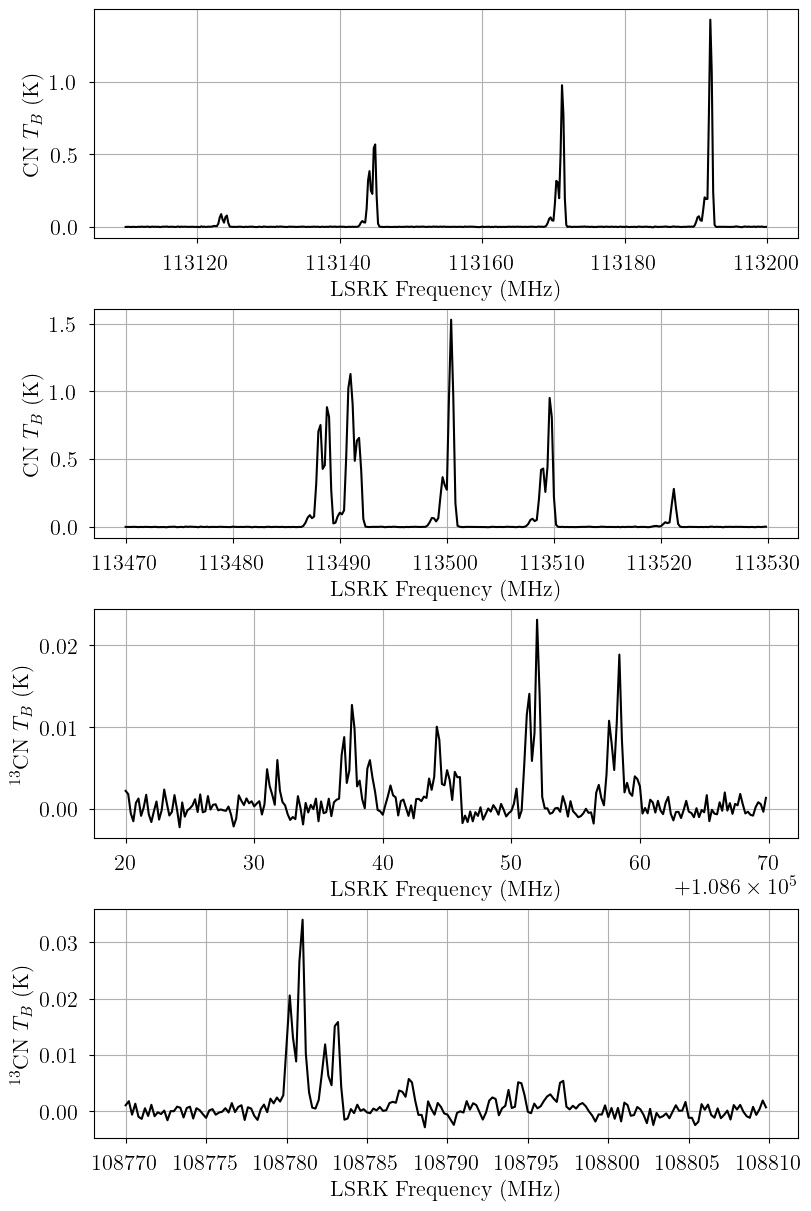

In [11]:
# Plot the simulated data
fig, axes = plt.subplots(4, layout="constrained", figsize=(8, 12))
for i, dataset in enumerate(data.values()):
    axes[i].plot(dataset.spectral, dataset.brightness, 'k-')
    axes[i].set_ylabel(dataset.ylabel)
    _ = axes[i].set_xlabel(dataset.xlabel)

In [12]:
sim_params

{'log10_Ntot1': array([13.8, 13.9, 14. ]),
 'ratio': array([0.01538462, 0.01666667, 0.01818182]),
 'fwhm2': array([1.    , 1.5625, 2.25  ]),
 'velocity': [-2.0, 0.0, 2.5],
 'log10_Tex_CTEX': array([0.64933486, 0.59988307, 0.49968708]),
 'log10_CTEX_variance': array([-1.5, -2. , -3. ]),
 'baseline_12CN-1_norm': [0.0],
 'baseline_12CN-2_norm': [0.0],
 'baseline_13CN-1_norm': [0.0],
 'baseline_13CN-2_norm': [0.0],
 'weights_12CN': array([[0.16891559, 0.34505736, 0.05498905, 0.10542328, 0.04917233,
         0.11235737, 0.16408502],
        [0.18900191, 0.38032492, 0.05025949, 0.08900217, 0.0491355 ,
         0.09683548, 0.14544053],
        [0.21728639, 0.43483541, 0.03868844, 0.07692791, 0.03936411,
         0.07765182, 0.11524591]]),
 'log10_Ntot_12CN': array([14.01632501, 13.9342864 , 13.35635678]),
 'log10_Ntot_13CN': array([12.20341165, 12.15613515, 11.61599409]),
 'CTEX_weights_12CN': array([[0.17675213, 0.3535841 , 0.05232473, 0.10459641, 0.0521133 ,
         0.10423952, 0.1563898 ]

## Model Definition

In [13]:
# Initialize and define the model
n_clouds = 3
mol_keys_rev = {"13CN": mol_keys["13CN"], "12CN": mol_keys["12CN"]}
model = HFSRatioModel(
    mol_data_12CN, # molecular data for species 1
    mol_data_13CN, # molecular data for species 2
    mol_keys, # dataset association
    data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_Ntot1 = [13.5, 0.5], # mean and width of log10 total column density prior of first species (cm-2)
    prior_ratio = 0.1, # width of the column density ratio between the second and first species
    prior_fwhm2 = 1.0, # width of FWHM^2 prior (km2 s-2)
    prior_velocity = [-3.0, 3.0], # upper and lower limit of velocity prior (km/s)
    prior_log10_Tex_CTEX = [0.75, 0.25], # mean and width of log10 CTEX excitation temperature prior (K)
    assume_CTEX1 = False, # do not assume CTEX for the first species
    assume_CTEX2 = True, # assume CTEX for the second species for efficiency
    prior_log10_CTEX_variance = [-4.0, 1.0], # offset and width of log10 CTEX variance prior
    clip_weights = 1.0e-9, # clip statistical weights between [clip_weights, 1-clip_weights]
    clip_tau = -10.0, # clip optical depths below to prevent masers
    prior_fwhm_L = None, # assume Gaussian line profile
    prior_baseline_coeffs = None, # use default baseline priors
)
model.add_likelihood()

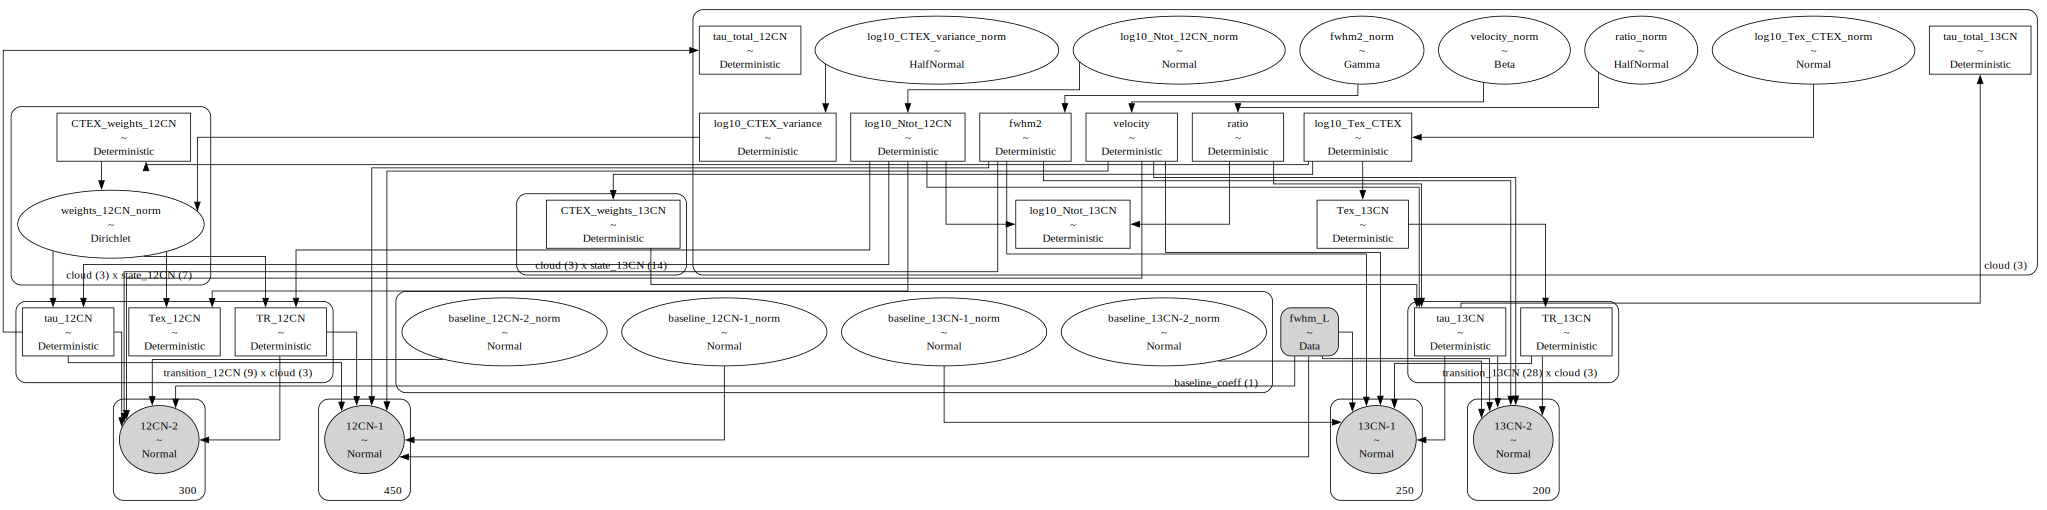

In [14]:
# Plot model graph
model.graph().render('hfs_ratio_model', format='png')
model.graph()

In [15]:
# model string representation
print(model.model.str_repr())

    baseline_12CN-1_norm ~ Normal(0, 1)
    baseline_12CN-2_norm ~ Normal(0, 1)
    baseline_13CN-1_norm ~ Normal(0, 1)
    baseline_13CN-2_norm ~ Normal(0, 1)
    log10_Ntot_12CN_norm ~ Normal(0, 1)
              ratio_norm ~ HalfNormal(0, 1)
              fwhm2_norm ~ Gamma(0.5, f())
           velocity_norm ~ Beta(2, 2)
     log10_Tex_CTEX_norm ~ Normal(0, 1)
log10_CTEX_variance_norm ~ HalfNormal(0, 1)
       weights_12CN_norm ~ Dirichlet(f(log10_CTEX_variance_norm, log10_Tex_CTEX_norm))
         log10_Ntot_12CN ~ Deterministic(f(log10_Ntot_12CN_norm))
                   ratio ~ Deterministic(f(ratio_norm))
                   fwhm2 ~ Deterministic(f(fwhm2_norm))
                velocity ~ Deterministic(f(velocity_norm))
          log10_Tex_CTEX ~ Deterministic(f(log10_Tex_CTEX_norm))
         log10_Ntot_13CN ~ Deterministic(f(ratio_norm, log10_Ntot_12CN_norm))
     log10_CTEX_variance ~ Deterministic(f(log10_CTEX_variance_norm))
       CTEX_weights_12CN ~ Deterministic(f(log10_Tex_C

Sampling: [12CN-1, 12CN-2, 13CN-1, 13CN-2, baseline_12CN-1_norm, baseline_12CN-2_norm, baseline_13CN-1_norm, baseline_13CN-2_norm, fwhm2_norm, log10_CTEX_variance_norm, log10_Ntot_12CN_norm, log10_Tex_CTEX_norm, ratio_norm, velocity_norm, weights_12CN_norm]


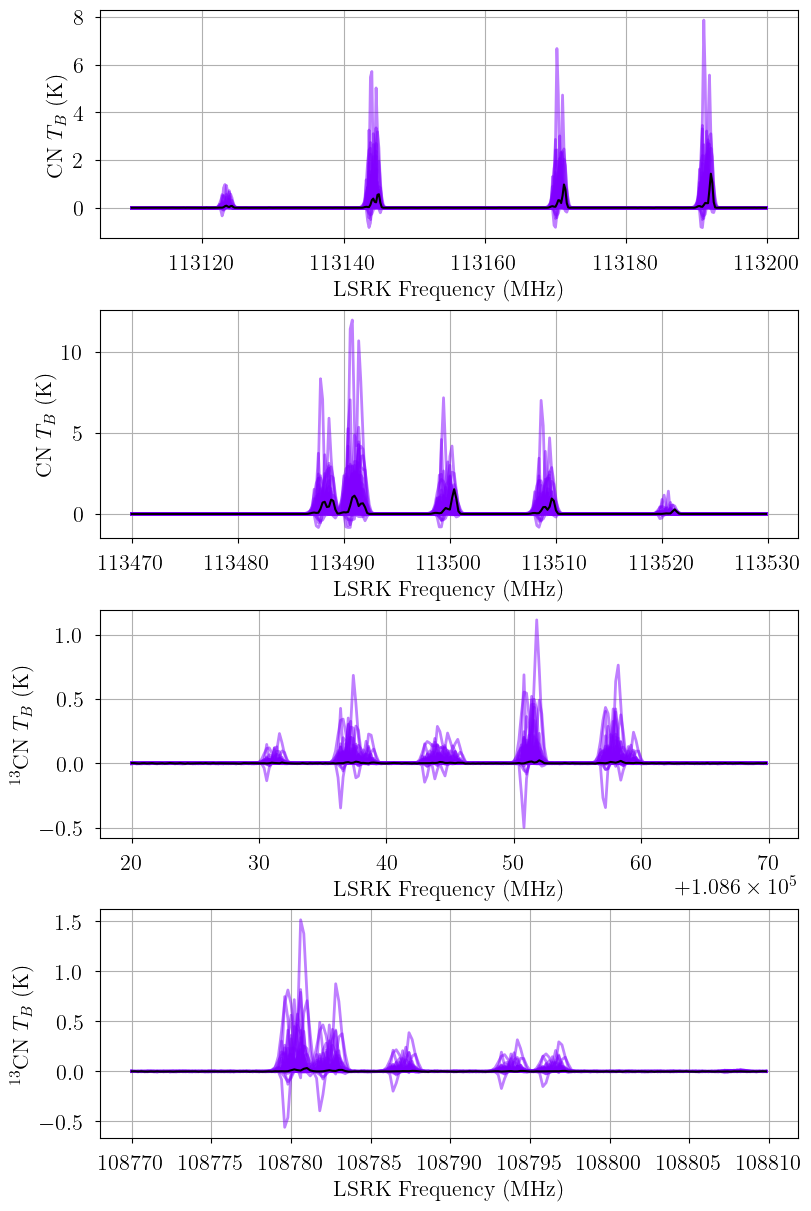

In [16]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=1000,  # prior predictive samples
)
axes = plot_predictive(model.data, prior.prior_predictive.sel(draw=slice(None, None, 20)))
axes.ravel()[0].figure.set_size_inches(8, 12)

In [17]:
print(model.cloud_freeRVs)
print(model.cloud_deterministics)

['log10_Ntot_12CN_norm', 'ratio_norm', 'fwhm2_norm', 'velocity_norm', 'log10_Tex_CTEX_norm', 'log10_CTEX_variance_norm', 'weights_12CN_norm']
['log10_Ntot_12CN', 'ratio', 'fwhm2', 'velocity', 'log10_Tex_CTEX', 'log10_Ntot_13CN', 'log10_CTEX_variance', 'CTEX_weights_12CN', 'Tex_12CN', 'tau_12CN', 'tau_total_12CN', 'TR_12CN', 'CTEX_weights_13CN', 'Tex_13CN', 'tau_13CN', 'tau_total_13CN', 'TR_13CN']


['log10_Ntot_12CN', 'ratio', 'fwhm2', 'velocity', 'log10_Tex_CTEX', 'log10_Ntot_13CN', 'log10_CTEX_variance', 'tau_total_12CN', 'Tex_13CN', 'tau_total_13CN']


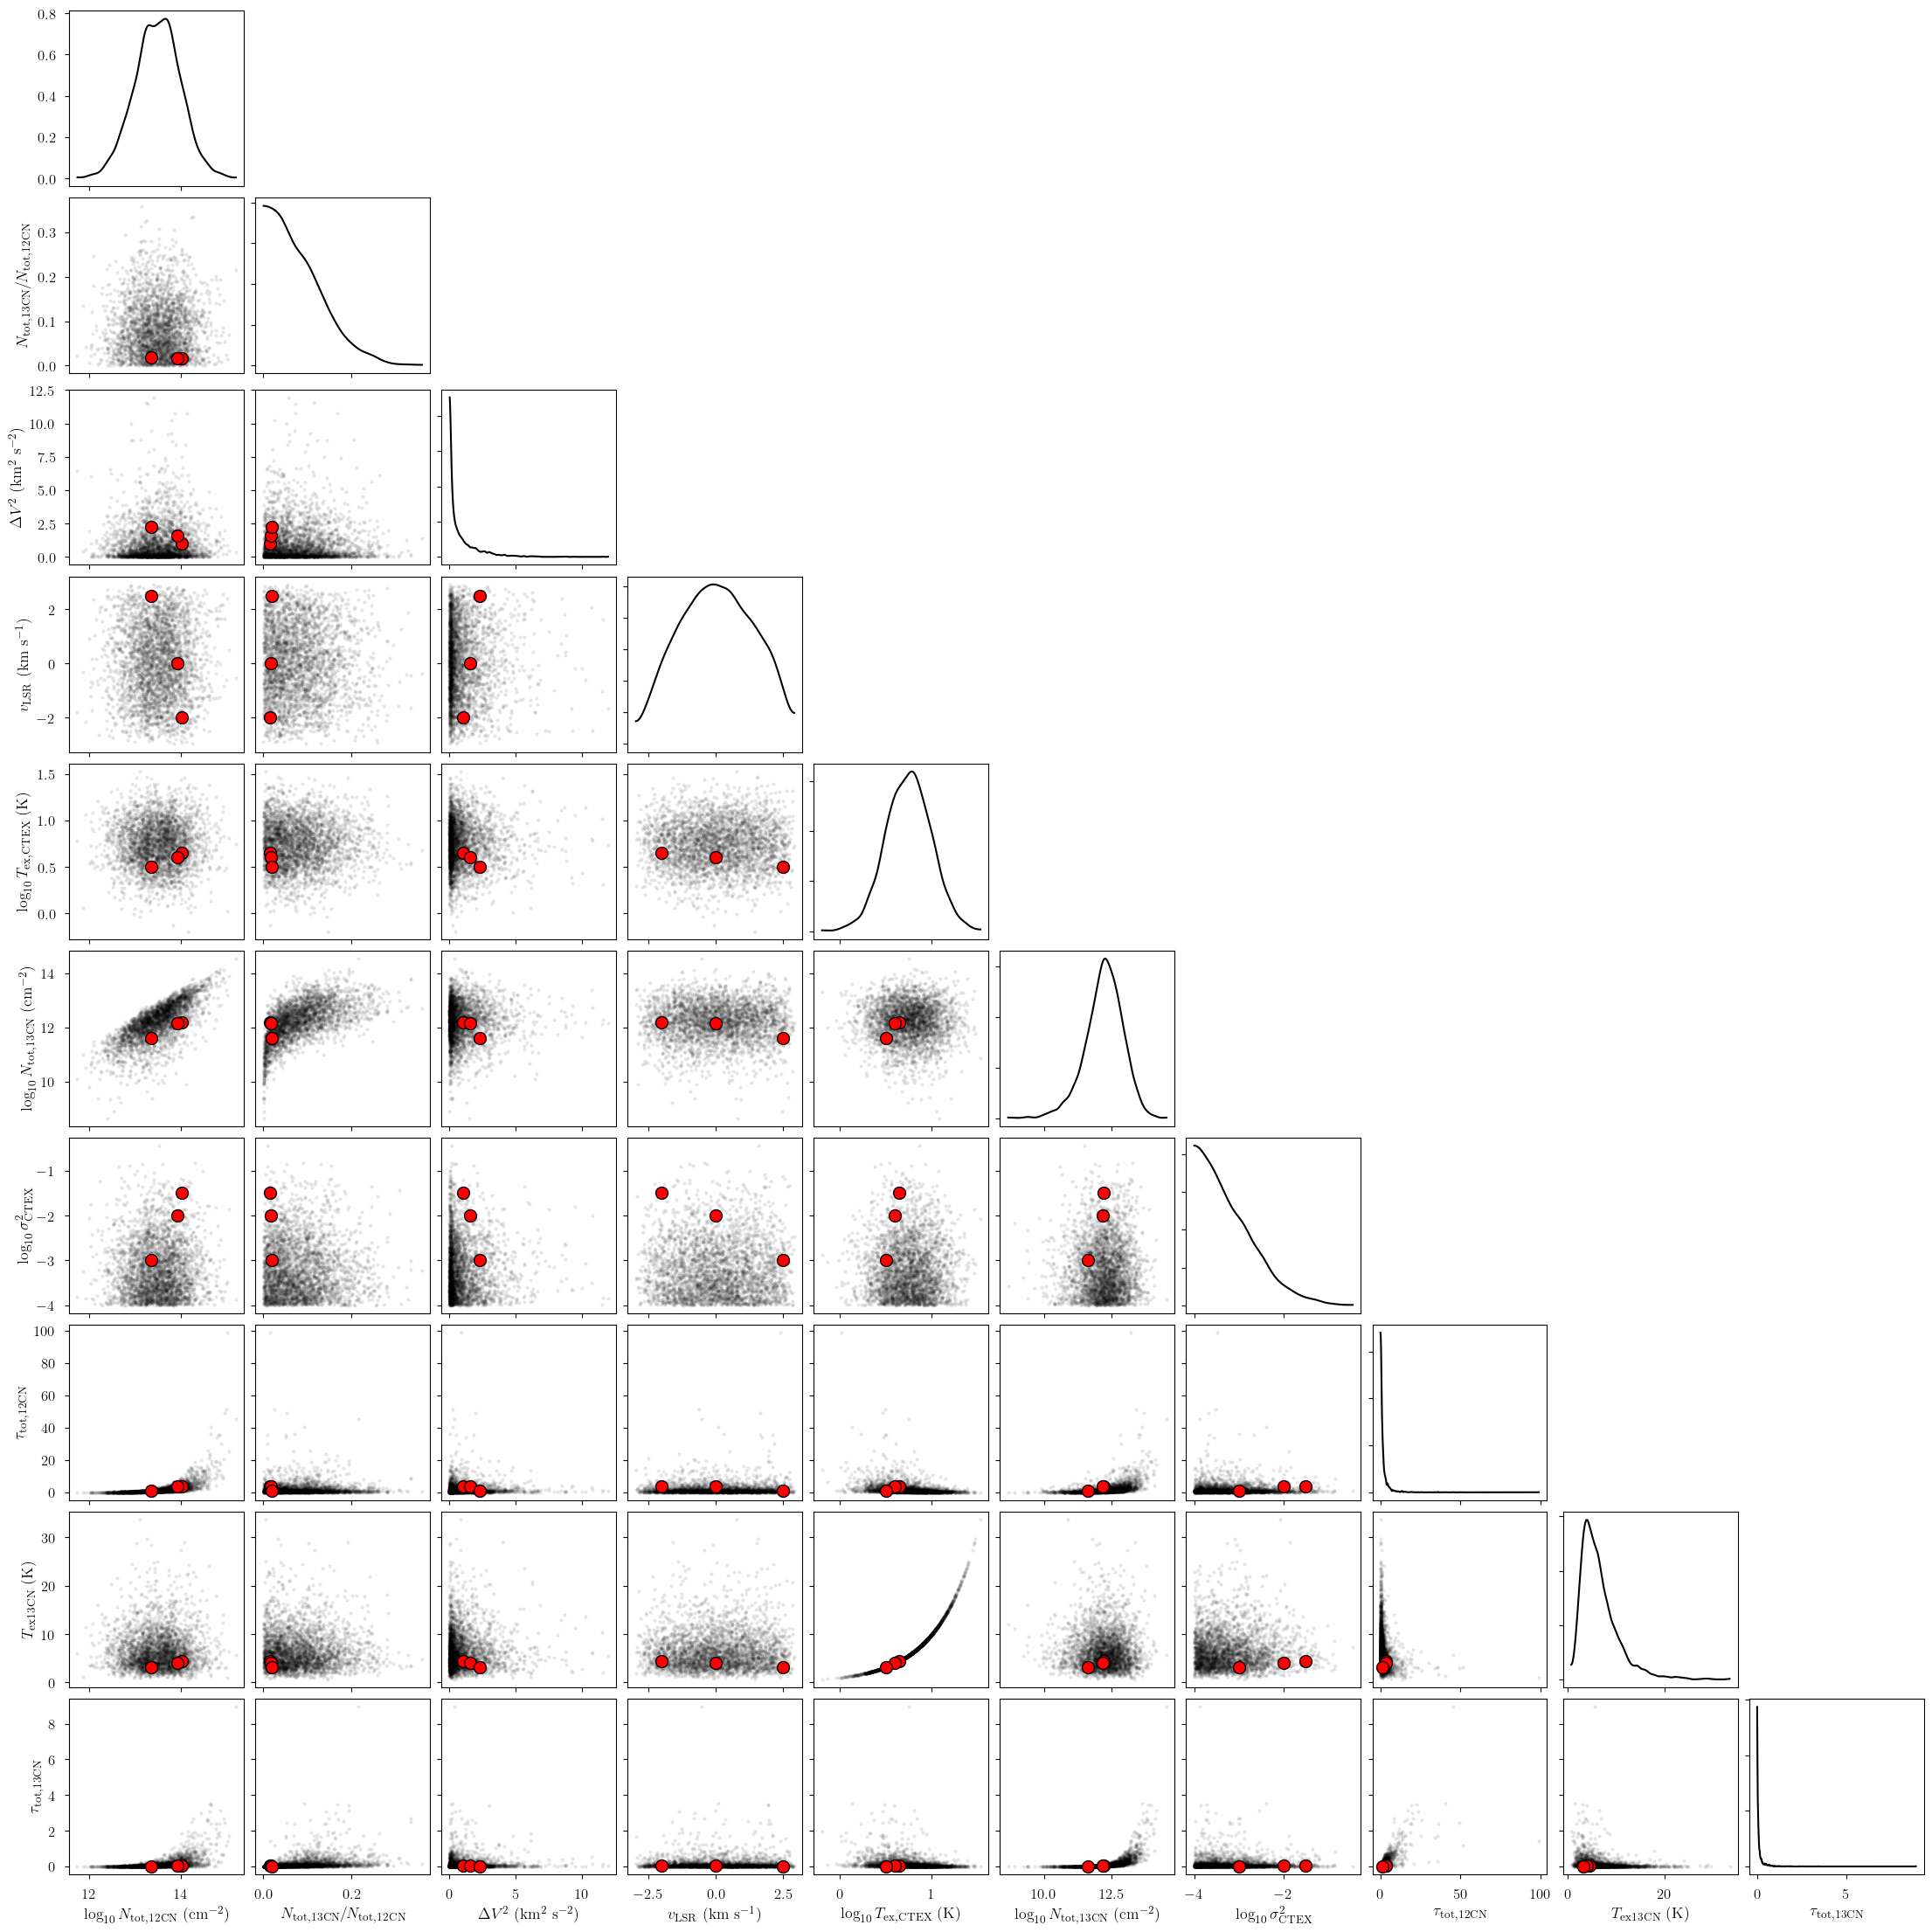

In [18]:
from bayes_spec.plots import plot_pair

var_names = [
    param for param in model.cloud_deterministics + [p for p in model.cloud_freeRVs if "_norm" not in p]
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition_12CN", "state_12CN", "transition_13CN", "state_13CN"]))
]
print(var_names)
_ = plot_pair(
    prior.prior, # samples
    var_names, # var_names to plot
    combine_dims=["cloud"], # concatenate clouds
    labeller=model.labeller, # label manager
    kind="scatter", # plot type
    reference_values=sim_params, # truths
)

## Variational Inference

In [19]:
start = time.time()
model.fit(
    n = 1_000_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.01, # VI absolute convergence threshold
    learning_rate = 0.001, # VI learning rate
    start = {"velocity_norm": np.linspace(0.1, 0.9, n_clouds)},
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 50500
Interrupted at 50,499 [5%]: Average Loss = 5.2365e+28


Adding log-likelihood to trace


Output()

Runtime: 19.12 minutes


In [20]:
pm.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  \
baseline_12CN-1_norm[0]               0.016  0.049  -0.077    0.106   
baseline_12CN-2_norm[0]              -0.050  0.058  -0.149    0.062   
baseline_13CN-1_norm[0]               0.033  0.065  -0.081    0.158   
baseline_13CN-2_norm[0]              -0.100  0.072  -0.224    0.048   
log10_Ntot_12CN_norm[0]               1.030  0.000   1.029    1.030   
log10_Ntot_12CN_norm[1]               0.835  0.001   0.834    0.836   
log10_Ntot_12CN_norm[2]              -1.835  0.003  -1.841   -1.830   
log10_Tex_CTEX_norm[0]               -0.354  0.017  -0.388   -0.323   
log10_Tex_CTEX_norm[1]               -0.302  0.035  -0.369   -0.241   
log10_Tex_CTEX_norm[2]                0.595  0.280   0.066    1.100   
ratio_norm[0]                         0.150  0.002   0.145    0.154   
ratio_norm[1]                         0.126  0.003   0.121    0.131   
ratio_norm[2]                         0.275  0.047   0.185    0.355   
fwhm2_norm[0]                         1.001  0.001   0.999    1.002   
fwhm2_norm[1]                         1.593  0.002   1.590    1.598   
fwhm2_norm[2]                         2.381  0.020   2.341    2.415   
velocity_norm[0]                      0.167  0.000   0.167    0.167   
velocity_norm[1]                      0.500  0.000   0.500    0.500   
velocity_norm[2]                      0.917  0.001   0.916    0.918   
log10_CTEX_variance_norm[0]           2.556  0.226   2.114    2.937   
log10_CTEX_variance_norm[1]           2.547  0.211   2.156    2.945   
log10_CTEX_variance_norm[2]           2.566  0.218   2.173    2.950   
weights_12CN_norm[0, 0 0 1 1 -- --]   0.197  0.000   0.197    0.197   
weights_12CN_norm[0, 0 0 1 2 -- --]   0.332  0.000   0.332    0.332   
weights_12CN_norm[0, 1 0 1 1 -- --]   0.044  0.000   0.044    0.044   
weights_12CN_norm[0, 1 0 1 2 -- --]   0.126  0.000   0.126    0.126   
weights_12CN_norm[0, 1 0 2 1 -- --]   0.079  0.000   0.079    0.079   
weights_12CN_norm[0, 1 0 2 2 -- --]   0.112  0.000   0.112    0.112   
weights_12CN_norm[0, 1 0 2 3 -- --]   0.110  0.000   0.110    0.110   
weights_12CN_norm[1, 0 0 1 1 -- --]   0.156  0.000   0.155    0.156   
weights_12CN_norm[1, 0 0 1 2 -- --]   0.412  0.000   0.412    0.412   
weights_12CN_norm[1, 1 0 1 1 -- --]   0.047  0.000   0.047    0.047   
weights_12CN_norm[1, 1 0 1 2 -- --]   0.074  0.000   0.074    0.074   
weights_12CN_norm[1, 1 0 2 1 -- --]   0.038  0.000   0.038    0.038   
weights_12CN_norm[1, 1 0 2 2 -- --]   0.101  0.000   0.101    0.101   
weights_12CN_norm[1, 1 0 2 3 -- --]   0.173  0.000   0.172    0.173   
weights_12CN_norm[2, 0 0 1 1 -- --]   0.100  0.000   0.100    0.101   
weights_12CN_norm[2, 0 0 1 2 -- --]   0.299  0.001   0.298    0.300   
weights_12CN_norm[2, 1 0 1 1 -- --]   0.057  0.000   0.057    0.058   
weights_12CN_norm[2, 1 0 1 2 -- --]   0.153  0.000   0.152    0.154   
weights_12CN_norm[2, 1 0 2 1 -- --]   0.079  0.000   0.078    0.080   
weights_12CN_norm[2, 1 0 2 2 -- --]   0.157  0.001   0.156    0.158   
weights_12CN_norm[2, 1 0 2 3 -- --]   0.154  0.001   0.152    0.157   
log10_Ntot_12CN[0]                   14.015  0.000  14.015   14.015   
log10_Ntot_12CN[1]                   13.918  0.000  13.917   13.918   
log10_Ntot_12CN[2]                   12.583  0.002  12.579   12.585   
ratio[0]                              0.015  0.000   0.015    0.015   
ratio[1]                              0.013  0.000   0.012    0.013   
ratio[2]                              0.027  0.005   0.019    0.036   
fwhm2[0]                              1.001  0.001   0.999    1.002   
fwhm2[1]                              1.593  0.002   1.590    1.598   
fwhm2[2]                              2.381  0.020   2.341    2.415   
velocity[0]                          -2.000  0.000  -2.000   -2.000   
velocity[1]                           0.000  0.000  -0.001    0.001   
velocity[2]                           2.502  0.003   2.496    2.508   
log10_Tex_CTEX[0]                     0.662  0.004   0.653    0

Sampling: [12CN-1, 12CN-2, 13CN-1, 13CN-2]


Output()

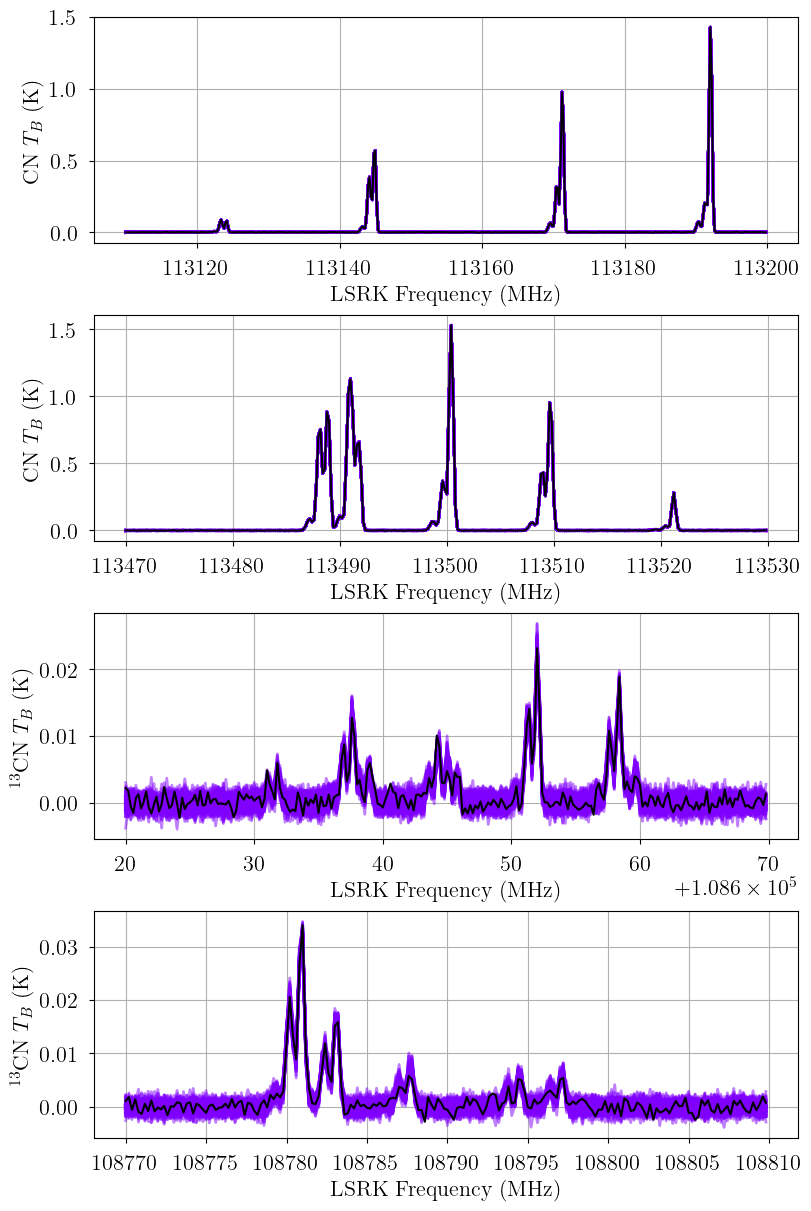

In [21]:
posterior = model.sample_posterior_predictive(
    thin=10, # keep one in {thin} posterior samples
)
axes = plot_predictive(model.data, posterior.posterior_predictive)
axes.ravel()[0].figure.set_size_inches(8, 12)

## Posterior Sampling: MCMC

In [22]:
start = time.time()
model.sample(
    init="advi+adapt_diag",  # initialization strategy
    tune=1000,  # tuning samples
    draws=1000,  # posterior samples
    chains=8,  # number of independent chains
    cores=8,  # number of parallel chains
    init_kwargs={
        "rel_tolerance": 0.01,
        "abs_tolerance": 0.01,
        "learning_rate": 0.001,
        "start": {"velocity_norm": np.linspace(0.1, 0.9, n_clouds)},
    },  # VI initialization arguments
    nuts_kwargs={"target_accept": 0.9},  # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 50500
Interrupted at 50,499 [5%]: Average Loss = 5.2365e+28
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, baseline_13CN-1_norm, baseline_13CN-2_norm, log10_Ntot_12CN_norm, ratio_norm, fwhm2_norm, velocity_norm, log10_Tex_CTEX_norm, log10_CTEX_variance_norm, weights_12CN_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 2180 seconds.


Adding log-likelihood to trace


Output()

There were 4 divergences in converged chains.
Runtime: 55.98 minutes


In [23]:
model.solve(
    init_params="random_from_data", # GMM initialization strategy
    n_init=10, # number of GMM initilizations
    max_iter=1_000, # maximum number of GMM iterations
    kl_div_threshold=0.1, # covergence threshold
)

GMM converged to unique solution


In [24]:
print("solutions:", model.solutions)

pm.summary(model.trace.solution_0)

solutions: [0]


mean     sd  hdi_3%  hdi_97%  \
baseline_12CN-1_norm[0]               0.023  0.049  -0.069    0.115   
baseline_12CN-2_norm[0]              -0.050  0.064  -0.175    0.066   
baseline_13CN-1_norm[0]               0.035  0.068  -0.093    0.164   
baseline_13CN-2_norm[0]              -0.097  0.075  -0.233    0.051   
log10_Ntot_12CN_norm[0]               1.029  0.003   1.023    1.034   
log10_Ntot_12CN_norm[1]               0.876  0.005   0.867    0.885   
log10_Ntot_12CN_norm[2]              -0.313  0.121  -0.551   -0.102   
log10_Tex_CTEX_norm[0]               -0.355  0.244  -0.802    0.092   
log10_Tex_CTEX_norm[1]               -0.605  0.174  -0.926   -0.273   
log10_Tex_CTEX_norm[2]               -1.015  0.050  -1.103   -0.919   
ratio_norm[0]                         0.160  0.037   0.097    0.224   
ratio_norm[1]                         0.175  0.055   0.106    0.258   
ratio_norm[2]                         0.248  0.057   0.147    0.350   
fwhm2_norm[0]                         1.003  0.002   1.000    1.007   
fwhm2_norm[1]                         1.556  0.005   1.546    1.565   
fwhm2_norm[2]                         2.233  0.043   2.149    2.311   
velocity_norm[0]                      0.167  0.000   0.167    0.167   
velocity_norm[1]                      0.500  0.000   0.500    0.500   
velocity_norm[2]                      0.916  0.001   0.915    0.917   
log10_CTEX_variance_norm[0]           2.606  0.236   2.181    3.063   
log10_CTEX_variance_norm[1]           2.410  0.236   1.999    2.866   
log10_CTEX_variance_norm[2]           1.202  0.288   0.686    1.740   
weights_12CN_norm[0, 0 0 1 1 -- --]   0.197  0.000   0.197    0.197   
weights_12CN_norm[0, 0 0 1 2 -- --]   0.332  0.000   0.331    0.332   
weights_12CN_norm[0, 1 0 1 1 -- --]   0.044  0.000   0.044    0.044   
weights_12CN_norm[0, 1 0 1 2 -- --]   0.126  0.000   0.126    0.126   
weights_12CN_norm[0, 1 0 2 1 -- --]   0.079  0.000   0.079    0.079   
weights_12CN_norm[0, 1 0 2 2 -- --]   0.112  0.000   0.112    0.113   
weights_12CN_norm[0, 1 0 2 3 -- --]   0.110  0.000   0.110    0.110   
weights_12CN_norm[1, 0 0 1 1 -- --]   0.158  0.000   0.157    0.159   
weights_12CN_norm[1, 0 0 1 2 -- --]   0.413  0.000   0.412    0.413   
weights_12CN_norm[1, 1 0 1 1 -- --]   0.047  0.000   0.046    0.047   
weights_12CN_norm[1, 1 0 1 2 -- --]   0.073  0.000   0.073    0.073   
weights_12CN_norm[1, 1 0 2 1 -- --]   0.038  0.000   0.038    0.038   
weights_12CN_norm[1, 1 0 2 2 -- --]   0.100  0.000   0.100    0.100   
weights_12CN_norm[1, 1 0 2 3 -- --]   0.172  0.000   0.171    0.172   
weights_12CN_norm[2, 0 0 1 1 -- --]   0.212  0.003   0.205    0.217   
weights_12CN_norm[2, 0 0 1 2 -- --]   0.442  0.004   0.434    0.449   
weights_12CN_norm[2, 1 0 1 1 -- --]   0.037  0.001   0.035    0.038   
weights_12CN_norm[2, 1 0 1 2 -- --]   0.080  0.002   0.076    0.084   
weights_12CN_norm[2, 1 0 2 1 -- --]   0.040  0.001   0.038    0.043   
weights_12CN_norm[2, 1 0 2 2 -- --]   0.081  0.002   0.077    0.085   
weights_12CN_norm[2, 1 0 2 3 -- --]   0.109  0.001   0.106    0.111   
log10_Ntot_12CN[0]                   14.015  0.001  14.012   14.017   
log10_Ntot_12CN[1]                   13.938  0.002  13.933   13.942   
log10_Ntot_12CN[2]                   13.344  0.060  13.224   13.449   
ratio[0]                              0.016  0.004   0.010    0.022   
ratio[1]                              0.018  0.005   0.011    0.026   
ratio[2]                              0.025  0.006   0.015    0.035   
fwhm2[0]                              1.003  0.002   1.000    1.007   
fwhm2[1]                              1.556  0.005   1.546    1.565   
fwhm2[2]                              2.233  0.043   2.149    2.311   
velocity[0]                          -2.000  0.000  -2.000   -2.000   
velocity[1]                           0.001  0.000   0.000    0.002   
velocity[2]                           2.495  0.004   2.488    2.502   
log10_Tex_CTEX[0]                     0.661  0.061   0.549    0

Sampling: [12CN-1, 12CN-2, 13CN-1, 13CN-2]


Output()

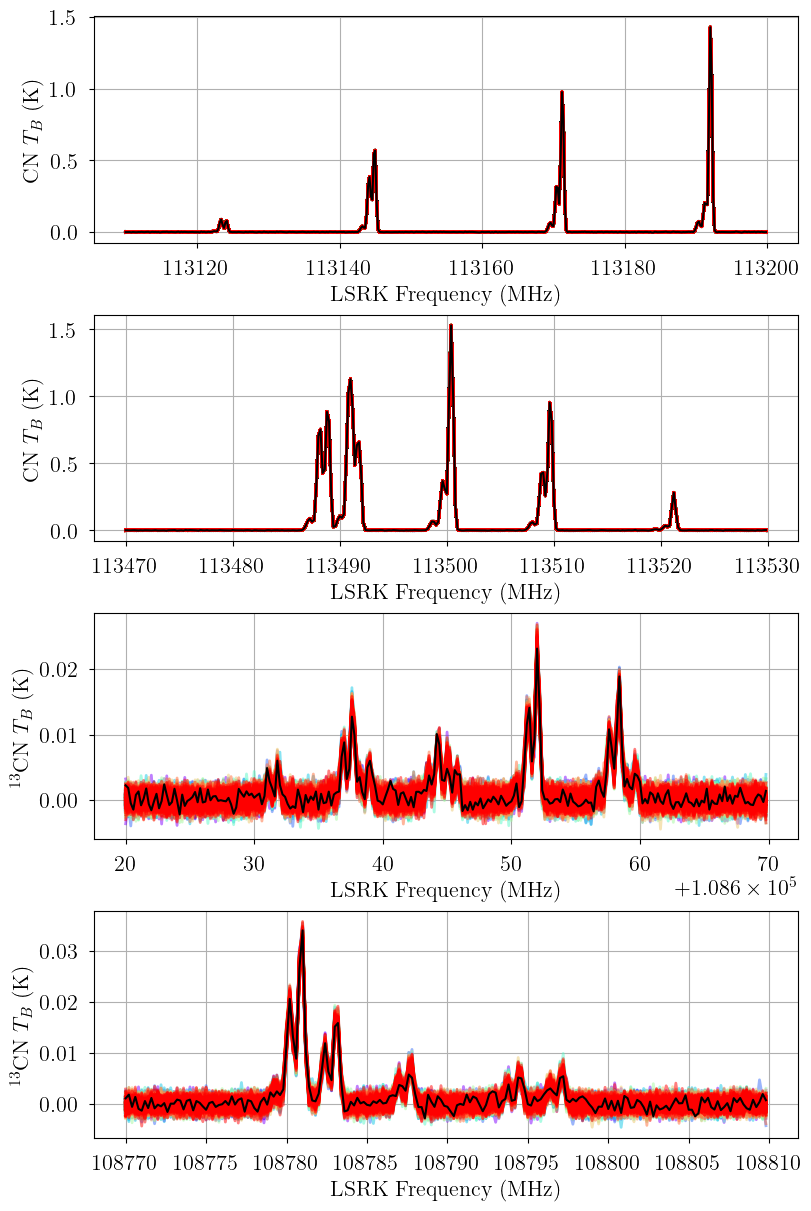

In [25]:
posterior = model.sample_posterior_predictive(
    thin=10, # keep one in {thin} posterior samples
)
axes = plot_predictive(model.data, posterior.posterior_predictive)
axes.ravel()[0].figure.set_size_inches(8, 12)

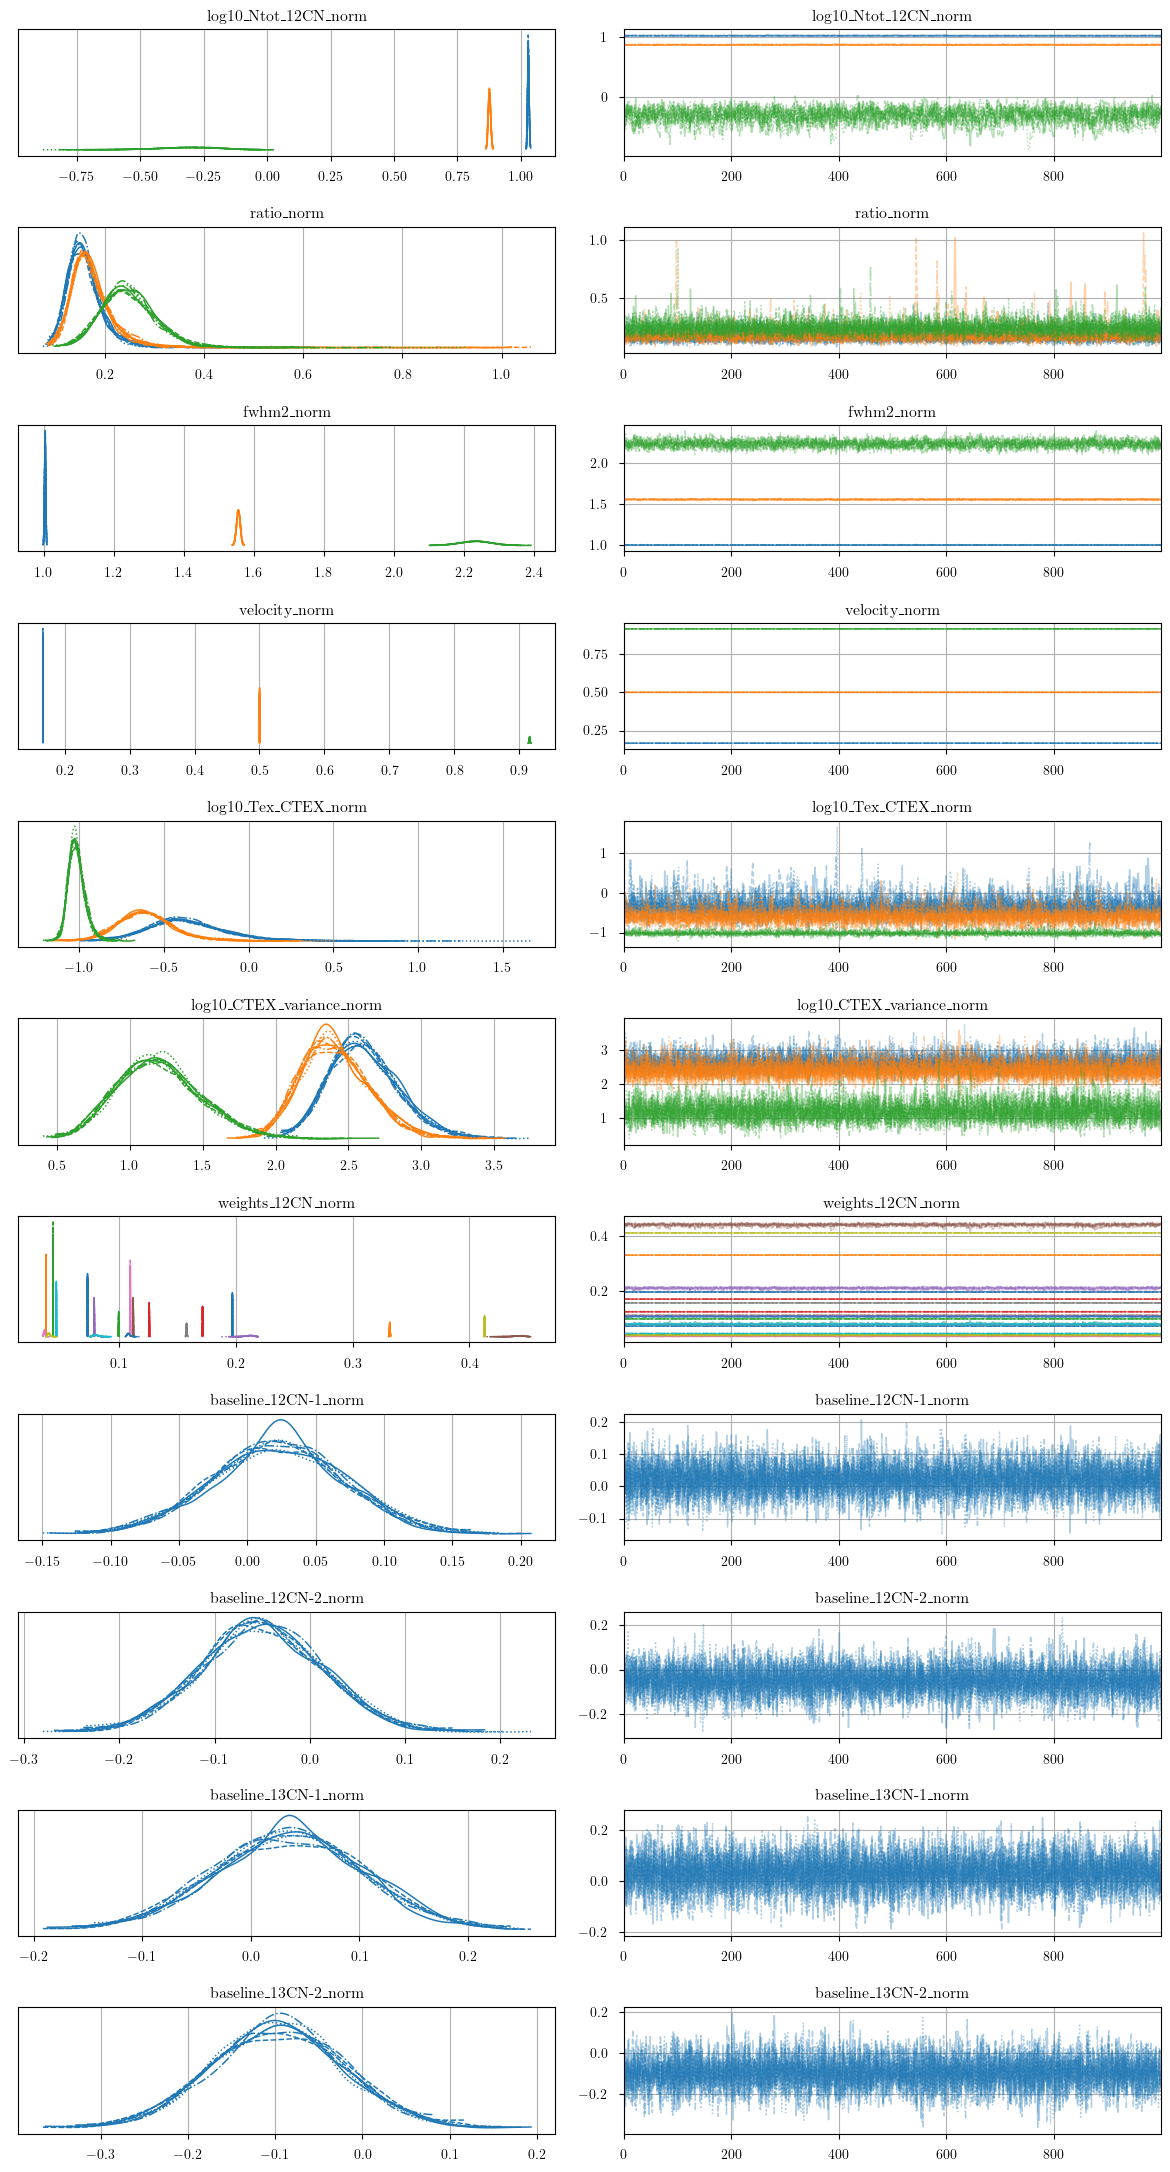

In [26]:
from bayes_spec.plots import plot_traces

axes = plot_traces(model.trace.posterior, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
fig = axes.ravel()[0].figure
fig.tight_layout()

['log10_Ntot_12CN_norm', 'ratio_norm', 'fwhm2_norm', 'velocity_norm', 'log10_Tex_CTEX_norm', 'log10_CTEX_variance_norm']


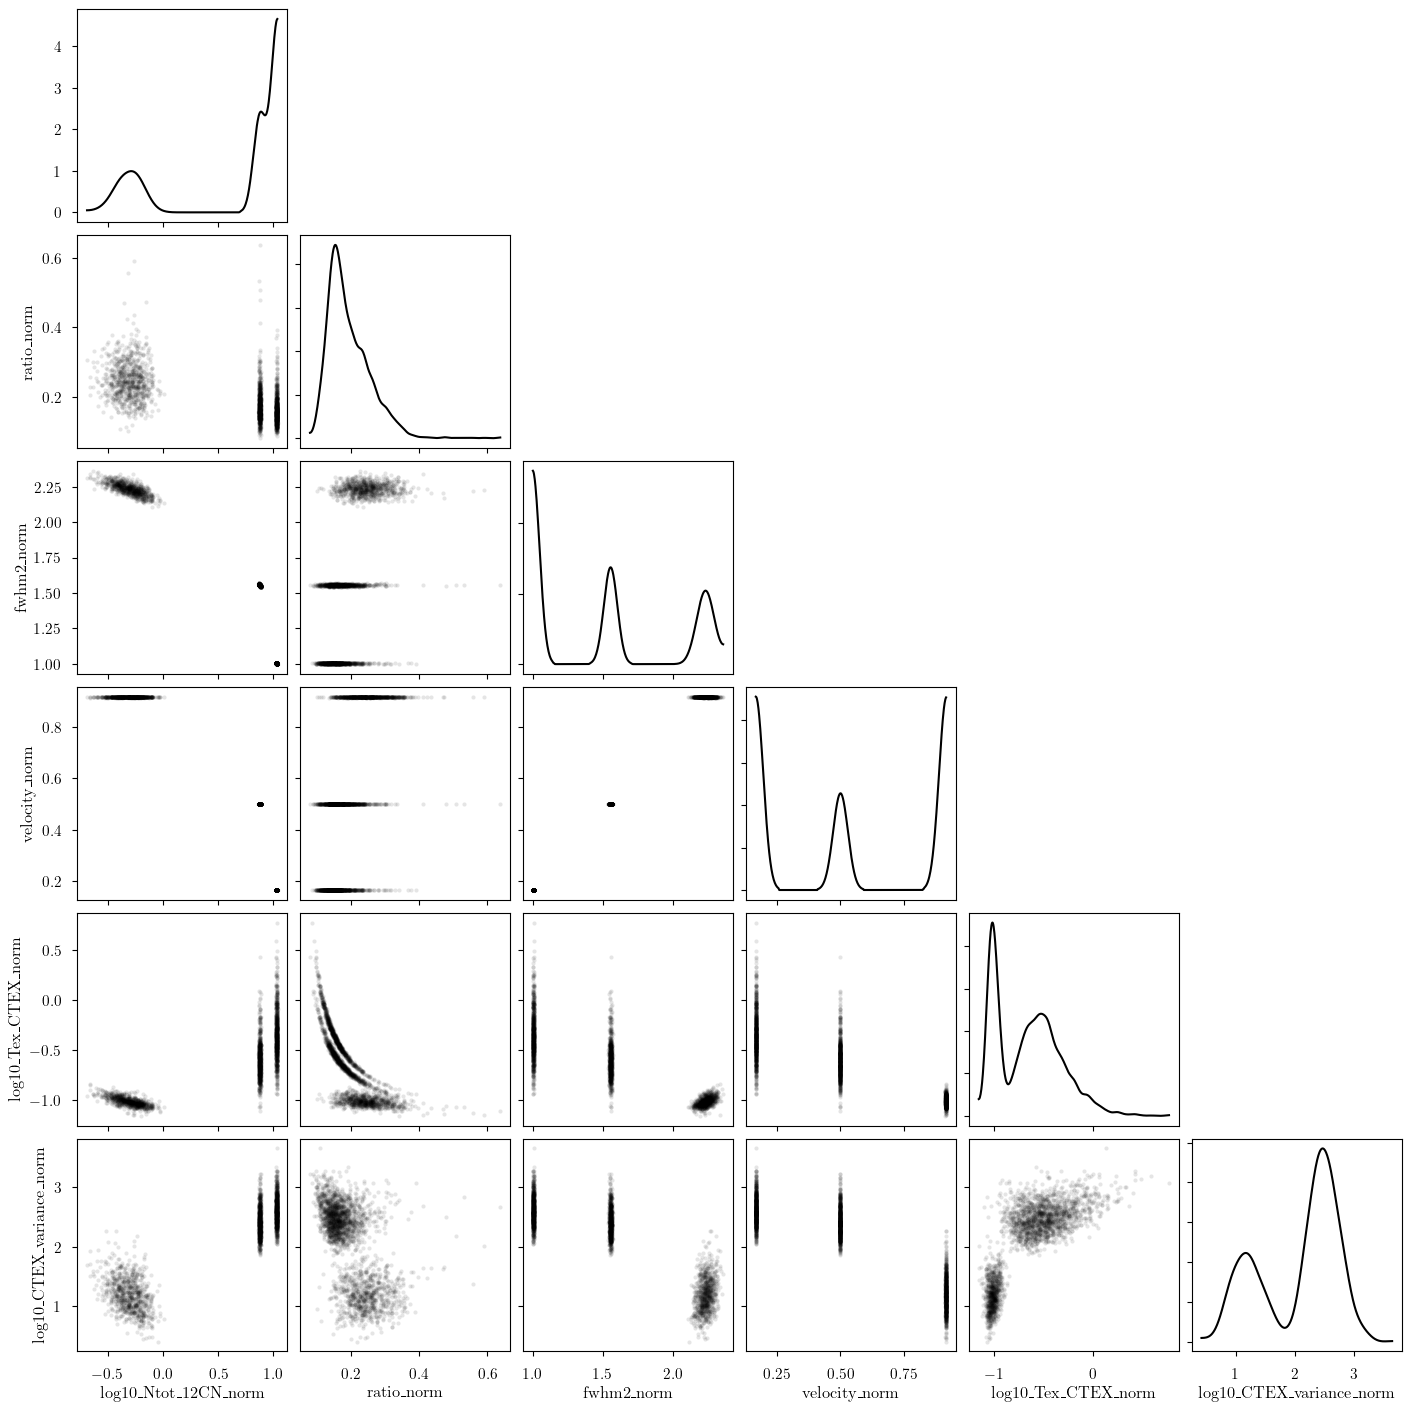

In [27]:
var_names = [
    param for param in model.cloud_freeRVs
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition_12CN", "state_12CN", "transition_13CN", "state_13CN"]))
]
print(var_names)
_ = plot_pair(
    model.trace.solution_0.sel(draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    combine_dims=["cloud"], # concatenate clouds
    kind="scatter", # plot type
)

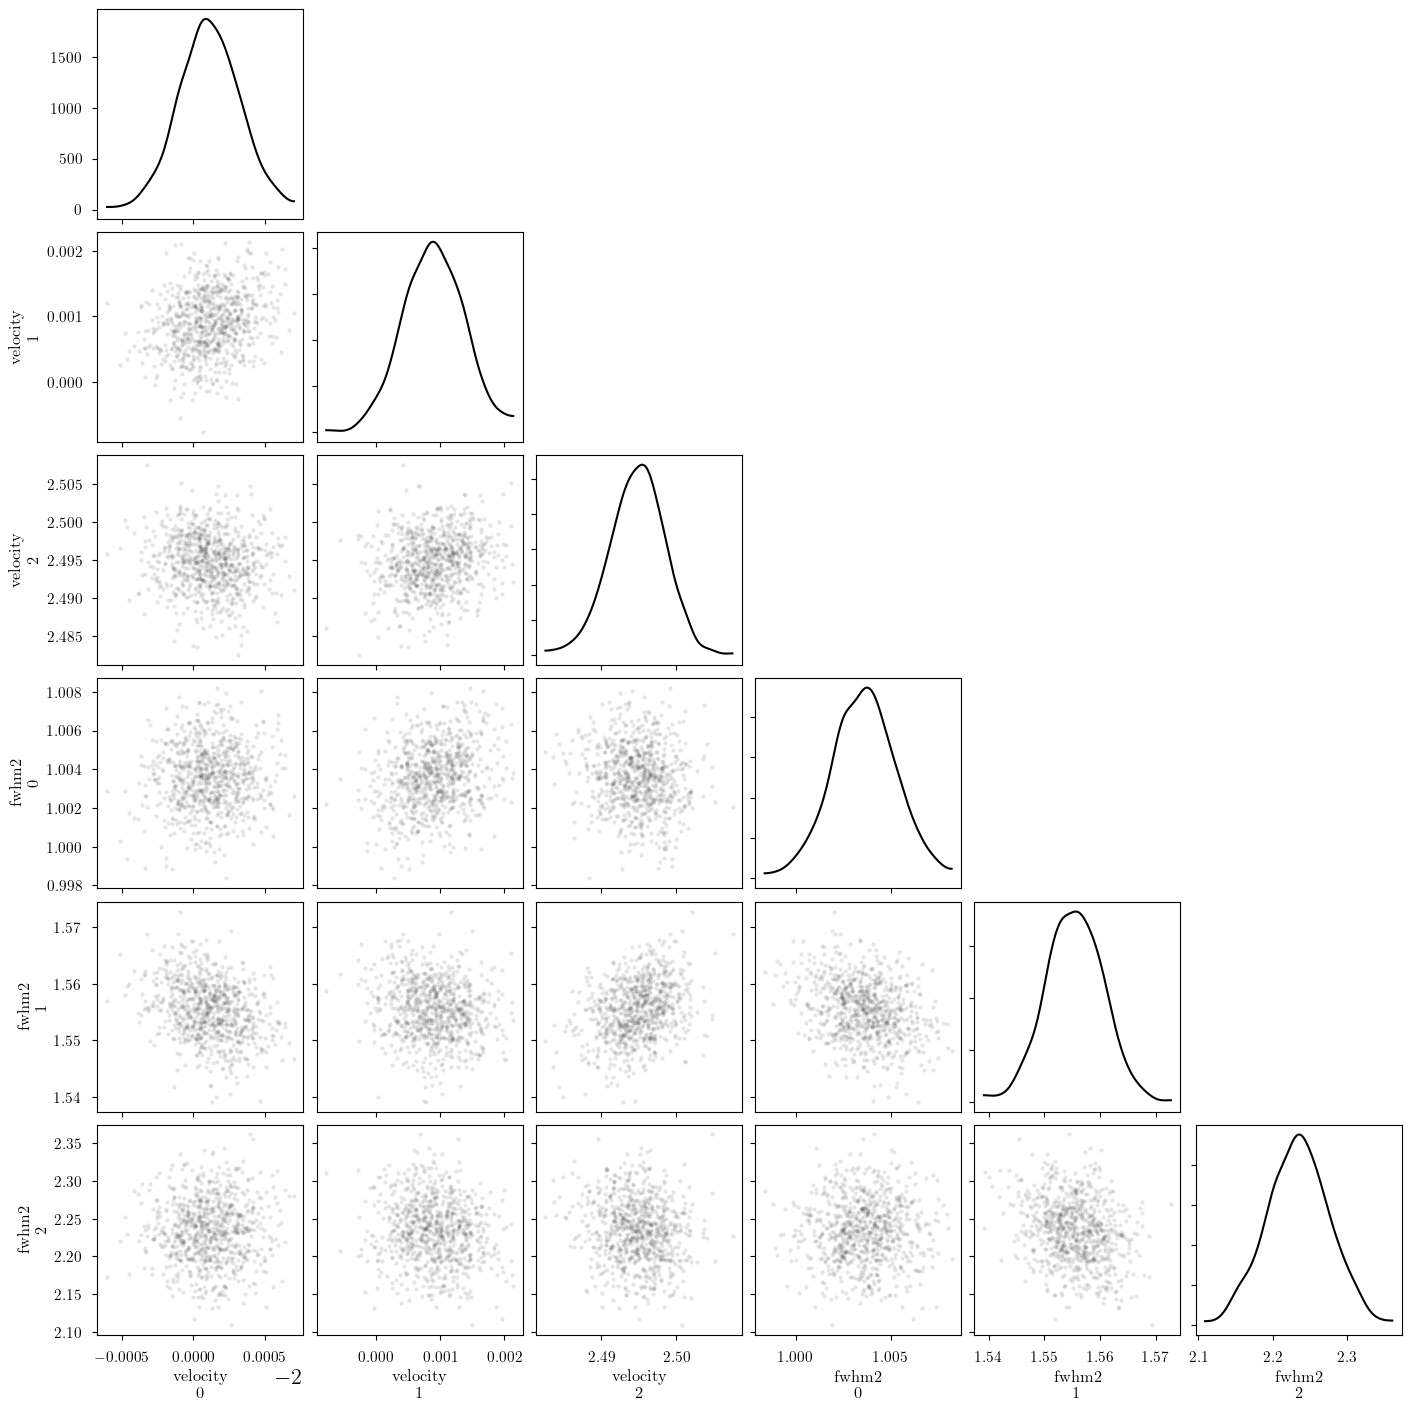

In [28]:
_ = plot_pair(
    model.trace.solution_0.sel(draw=slice(None, None, 10)), # samples
    ["velocity", "fwhm2"], # var_names to plot
    combine_dims=None, # do not concatenate clouds
    kind="scatter", # plot type
)

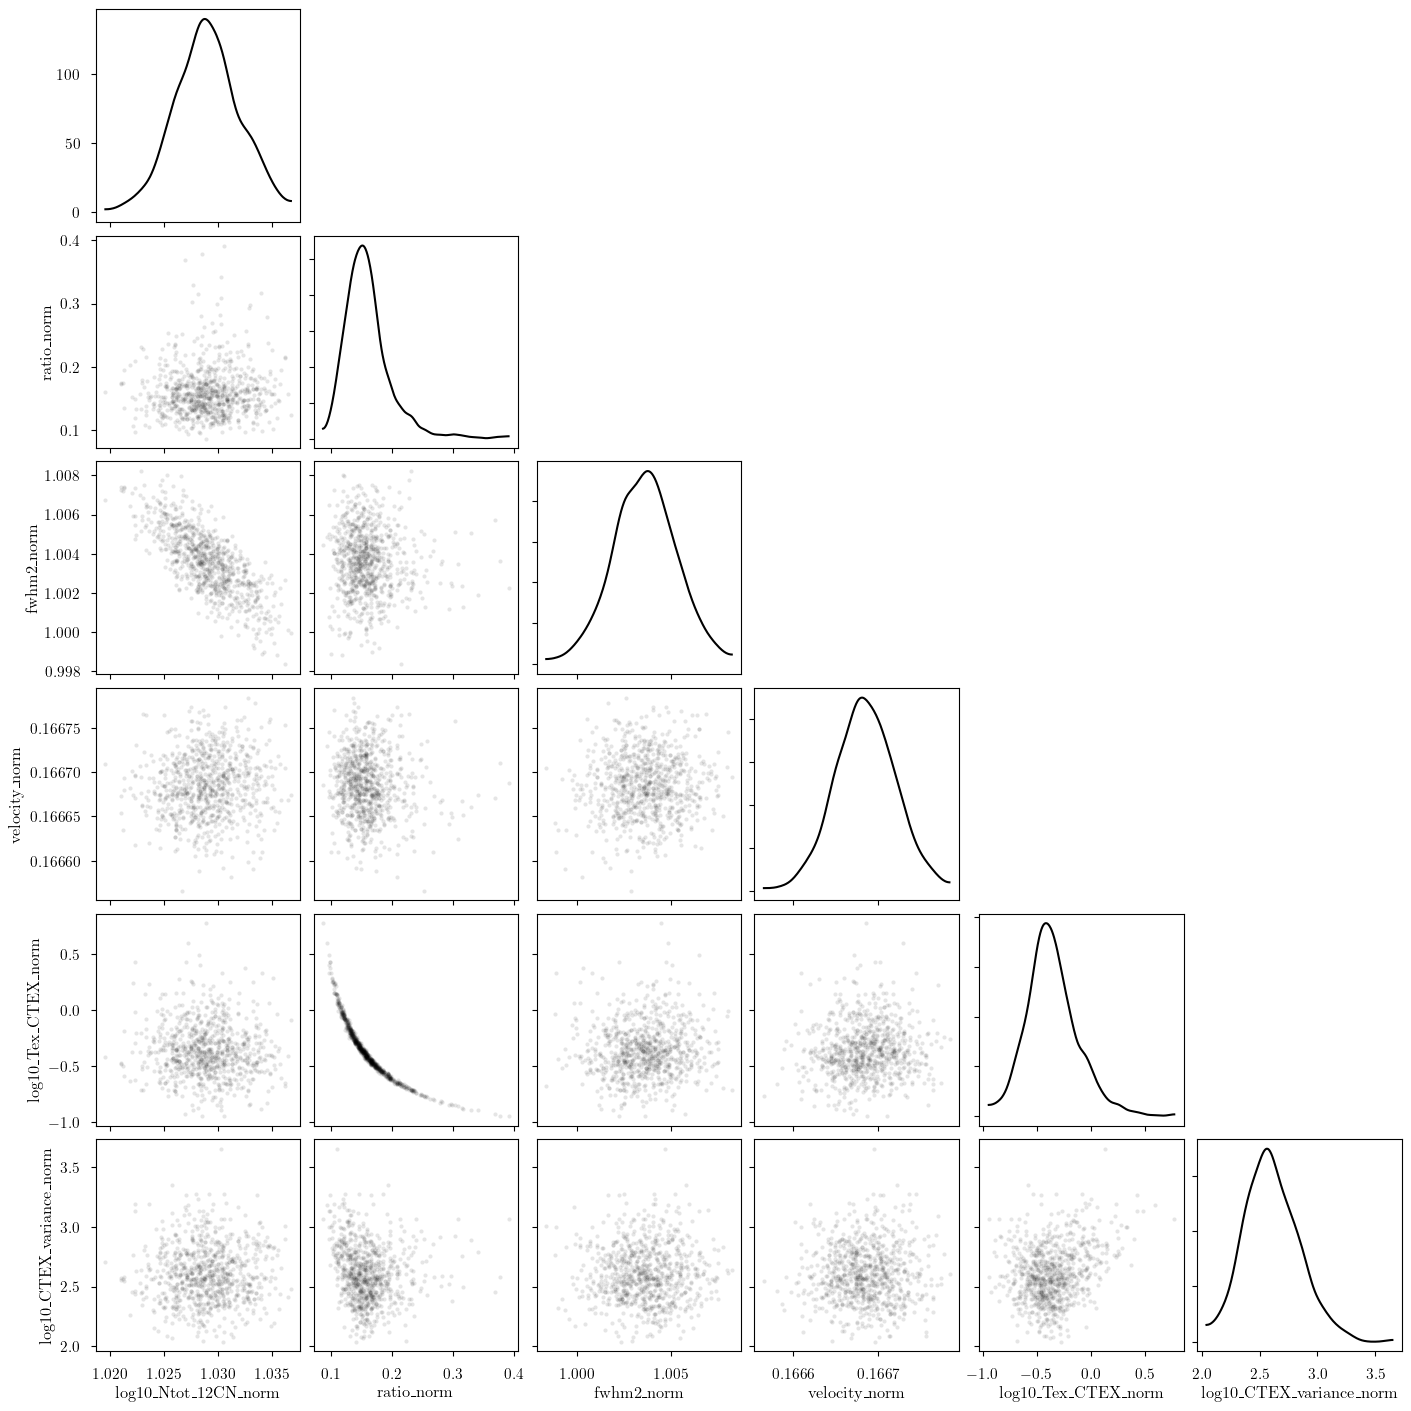

In [29]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0, draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    kind="scatter", # plot type
)

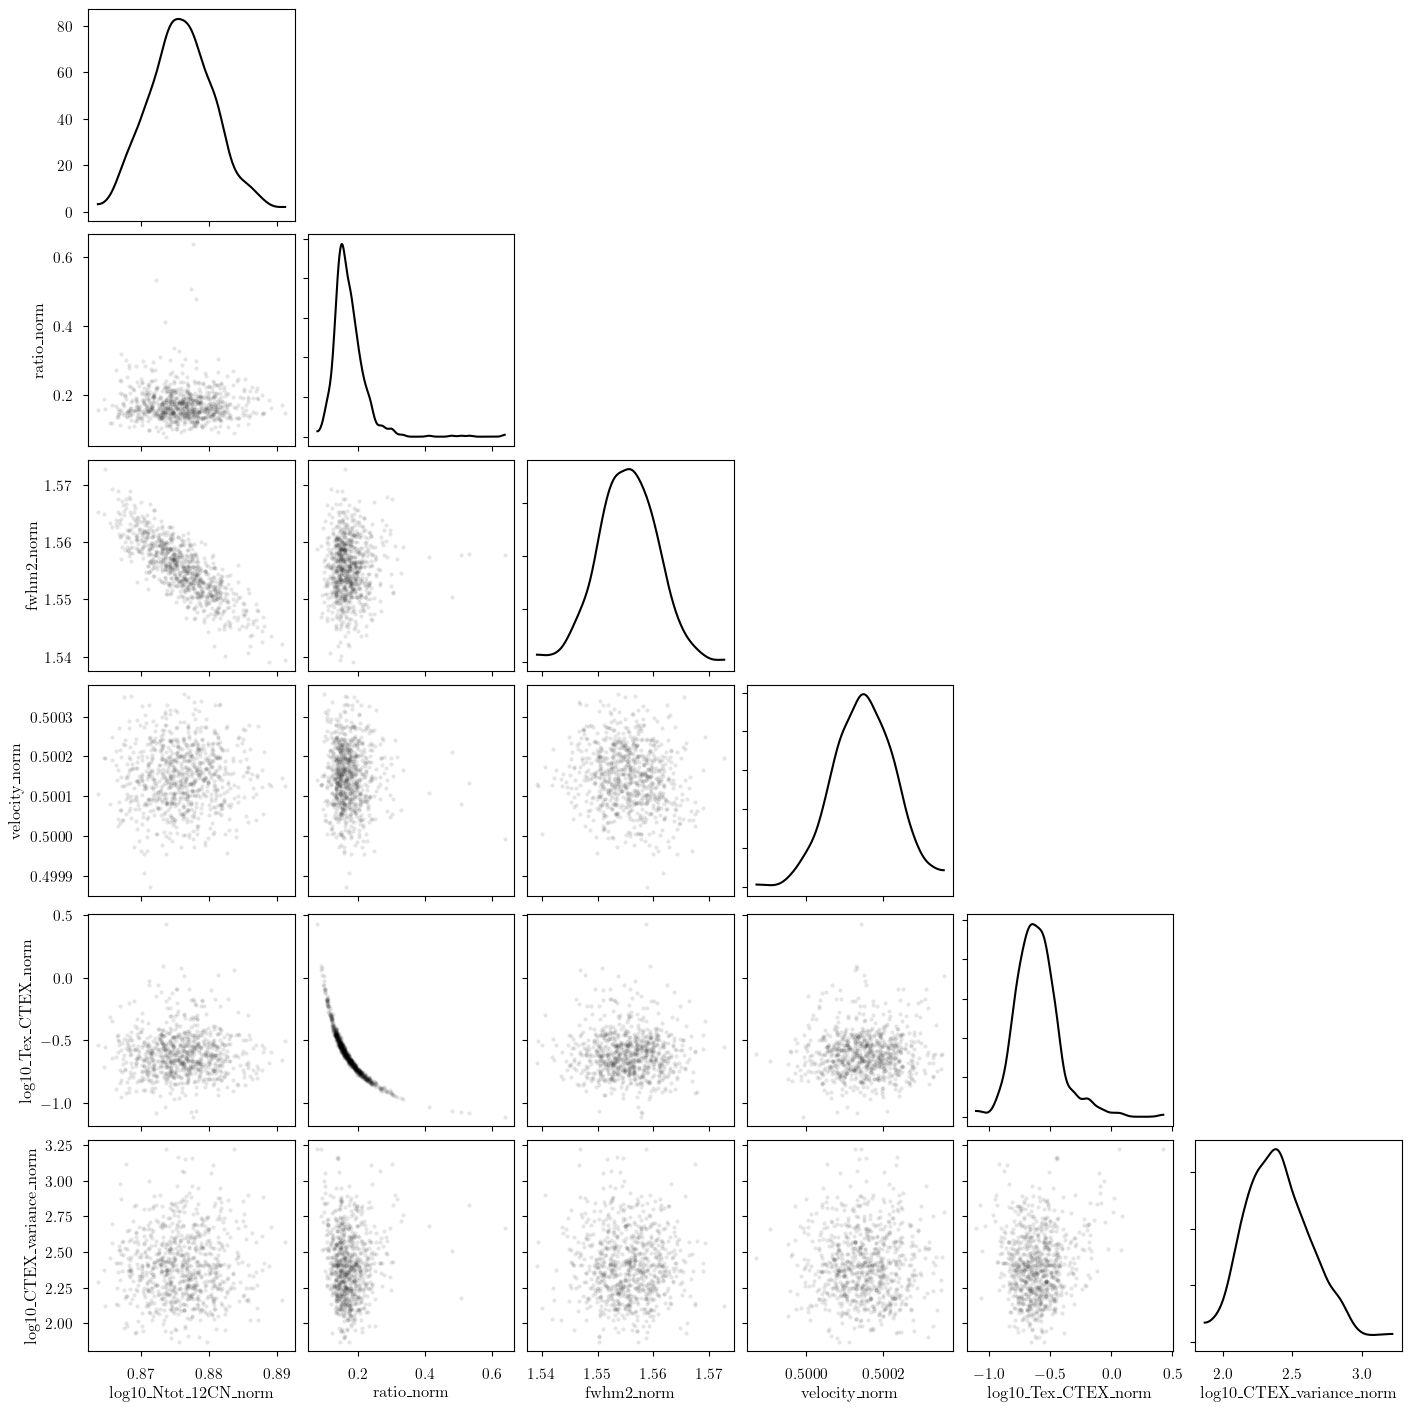

In [30]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=1, draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    kind="scatter", # plot type
)

['log10_Ntot_12CN', 'ratio', 'fwhm2', 'velocity', 'log10_Tex_CTEX', 'log10_Ntot_13CN', 'log10_CTEX_variance', 'tau_total_12CN', 'Tex_13CN', 'tau_total_13CN']


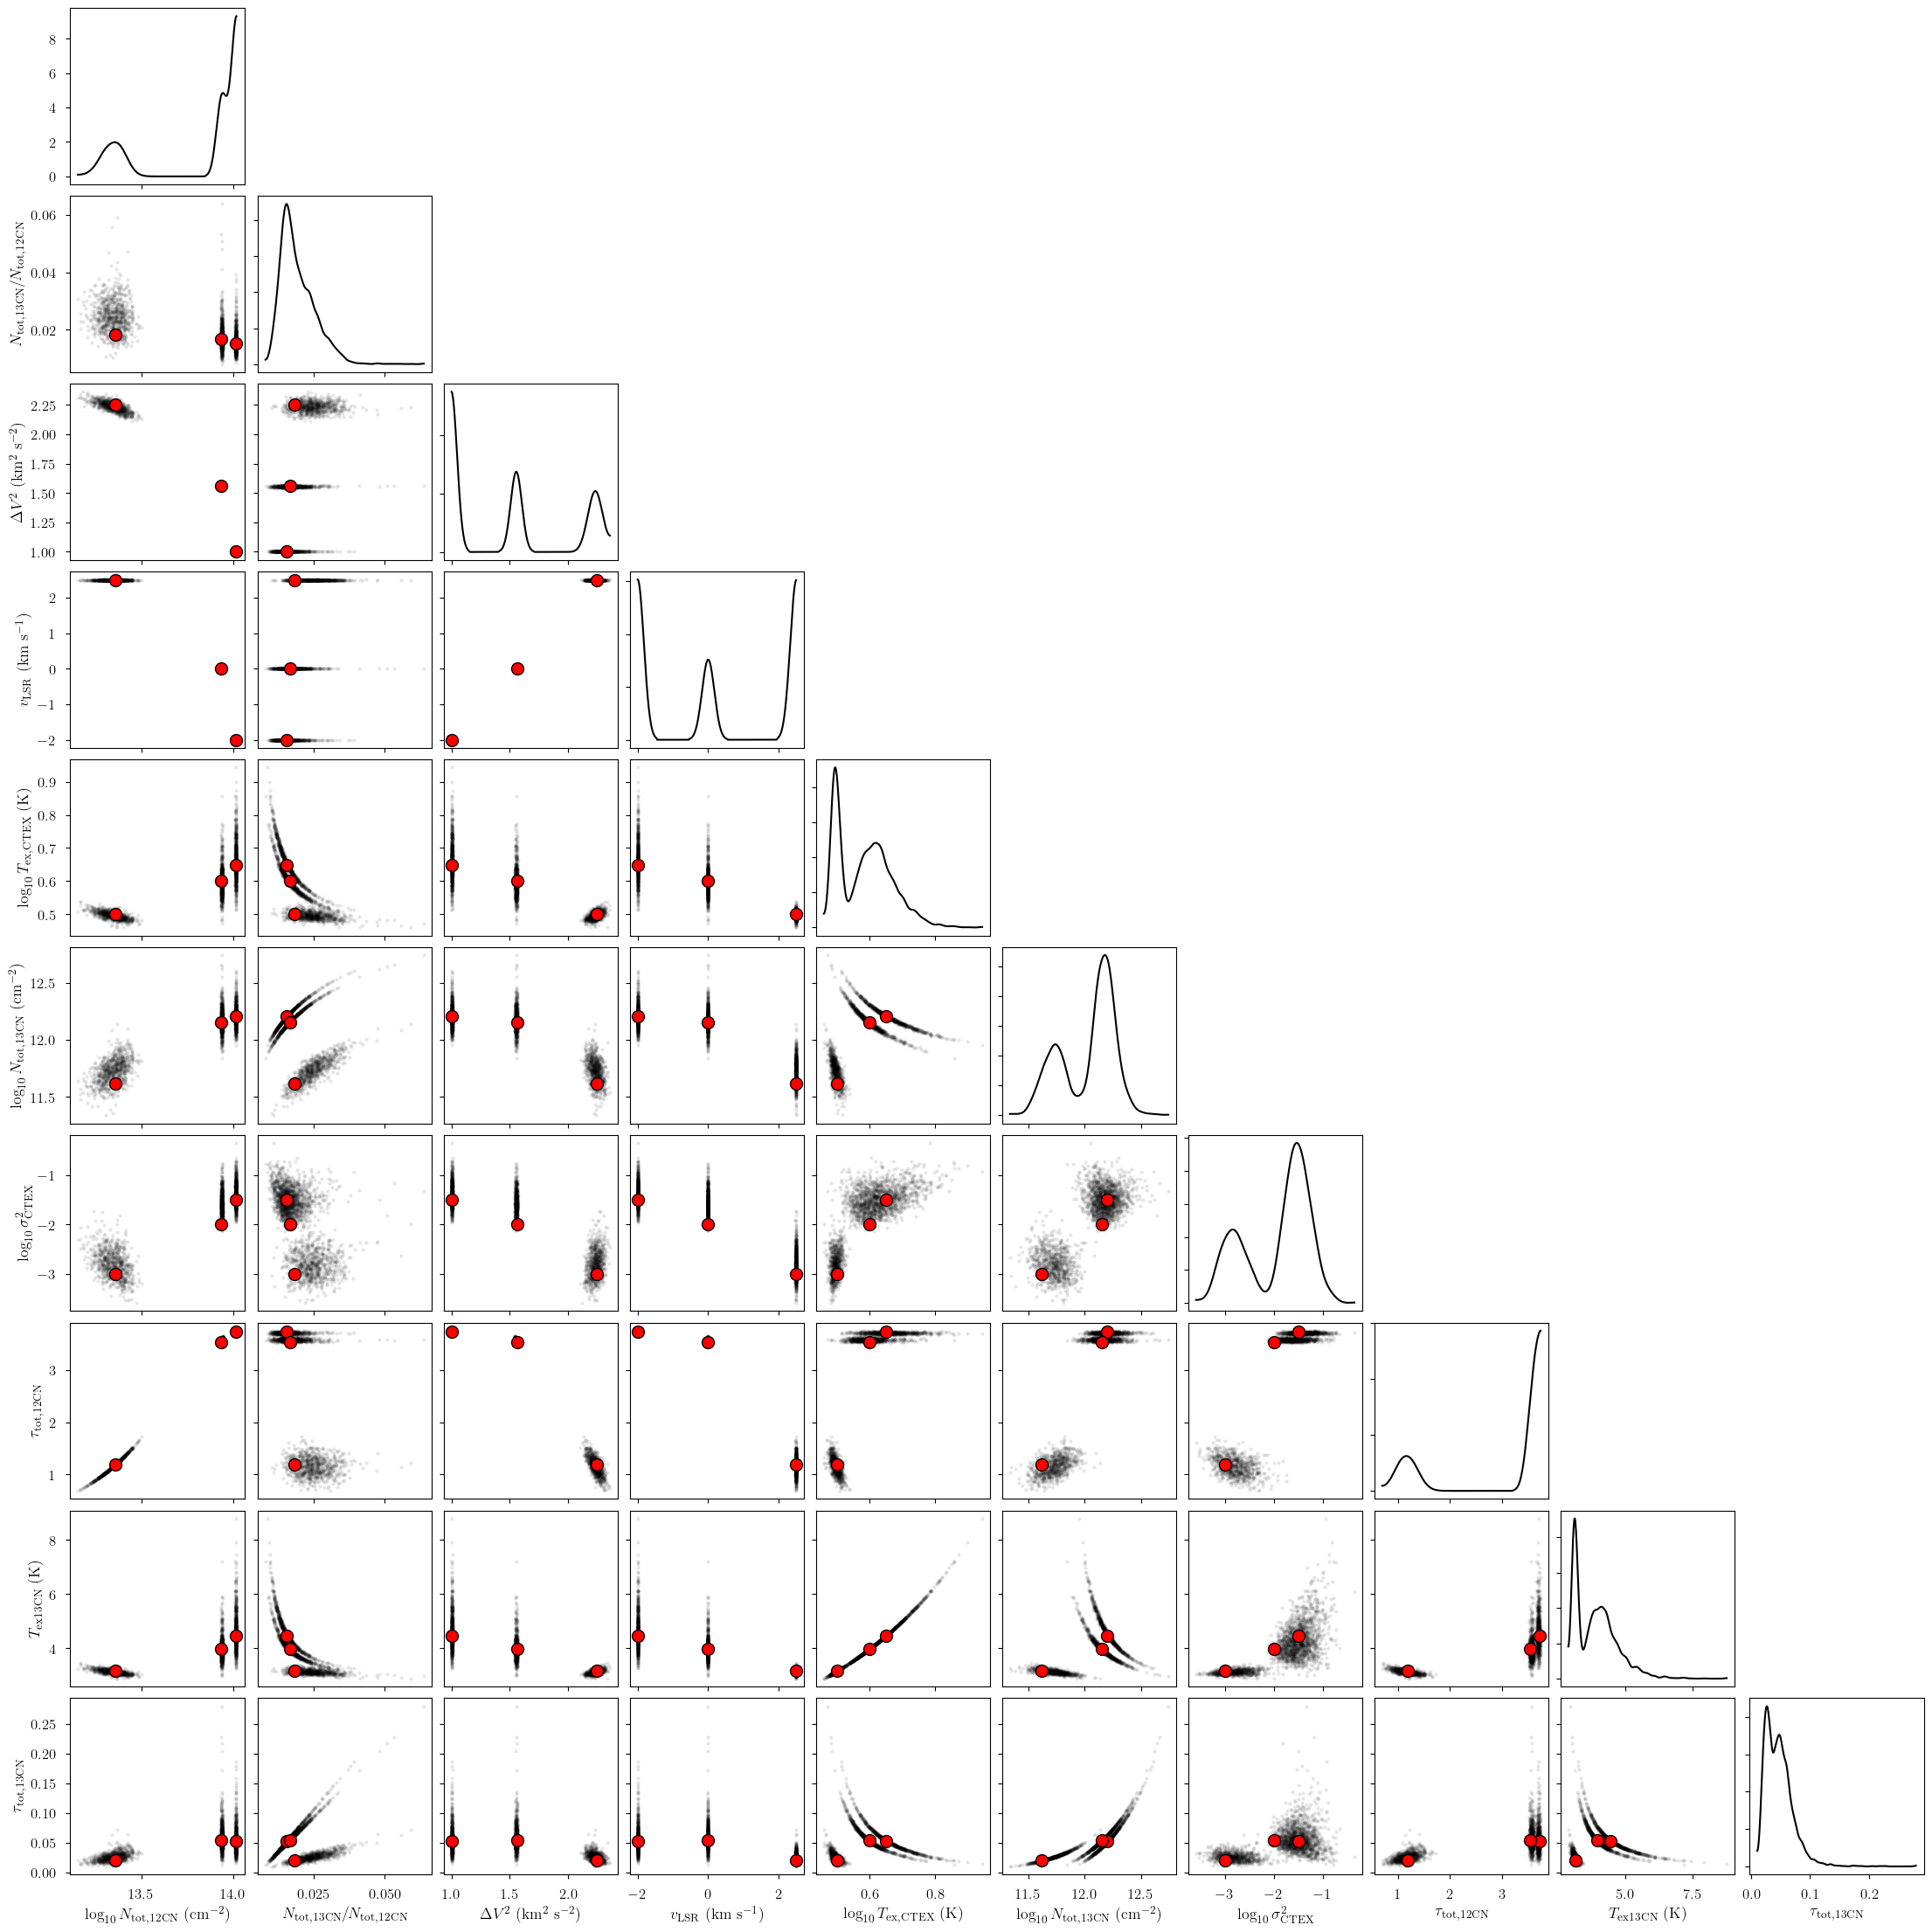

In [31]:
var_names = [
    param for param in model.cloud_deterministics + [p for p in model.cloud_freeRVs if "_norm" not in p]
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition_12CN", "state_12CN", "transition_13CN", "state_13CN"]))
]
print(var_names)
_ = plot_pair(
    model.trace.solution_0.sel(draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    combine_dims=["cloud"], # concatenate clouds
    labeller=model.labeller, # label manager
    kind="scatter", # plot type
    reference_values=sim_params, # truths
)

In [32]:
# identify simulation cloud corresponding to each posterior cloud
sim_cloud_map = {}
for i in range(n_clouds):
    posterior_velocity = model.trace.solution_0['velocity'].sel(cloud=i).data.mean()
    match = np.argmin(np.abs(sim_params["velocity"] - posterior_velocity))
    sim_cloud_map[i] = match
sim_cloud_map

{0: np.int64(0), 1: np.int64(1), 2: np.int64(2)}

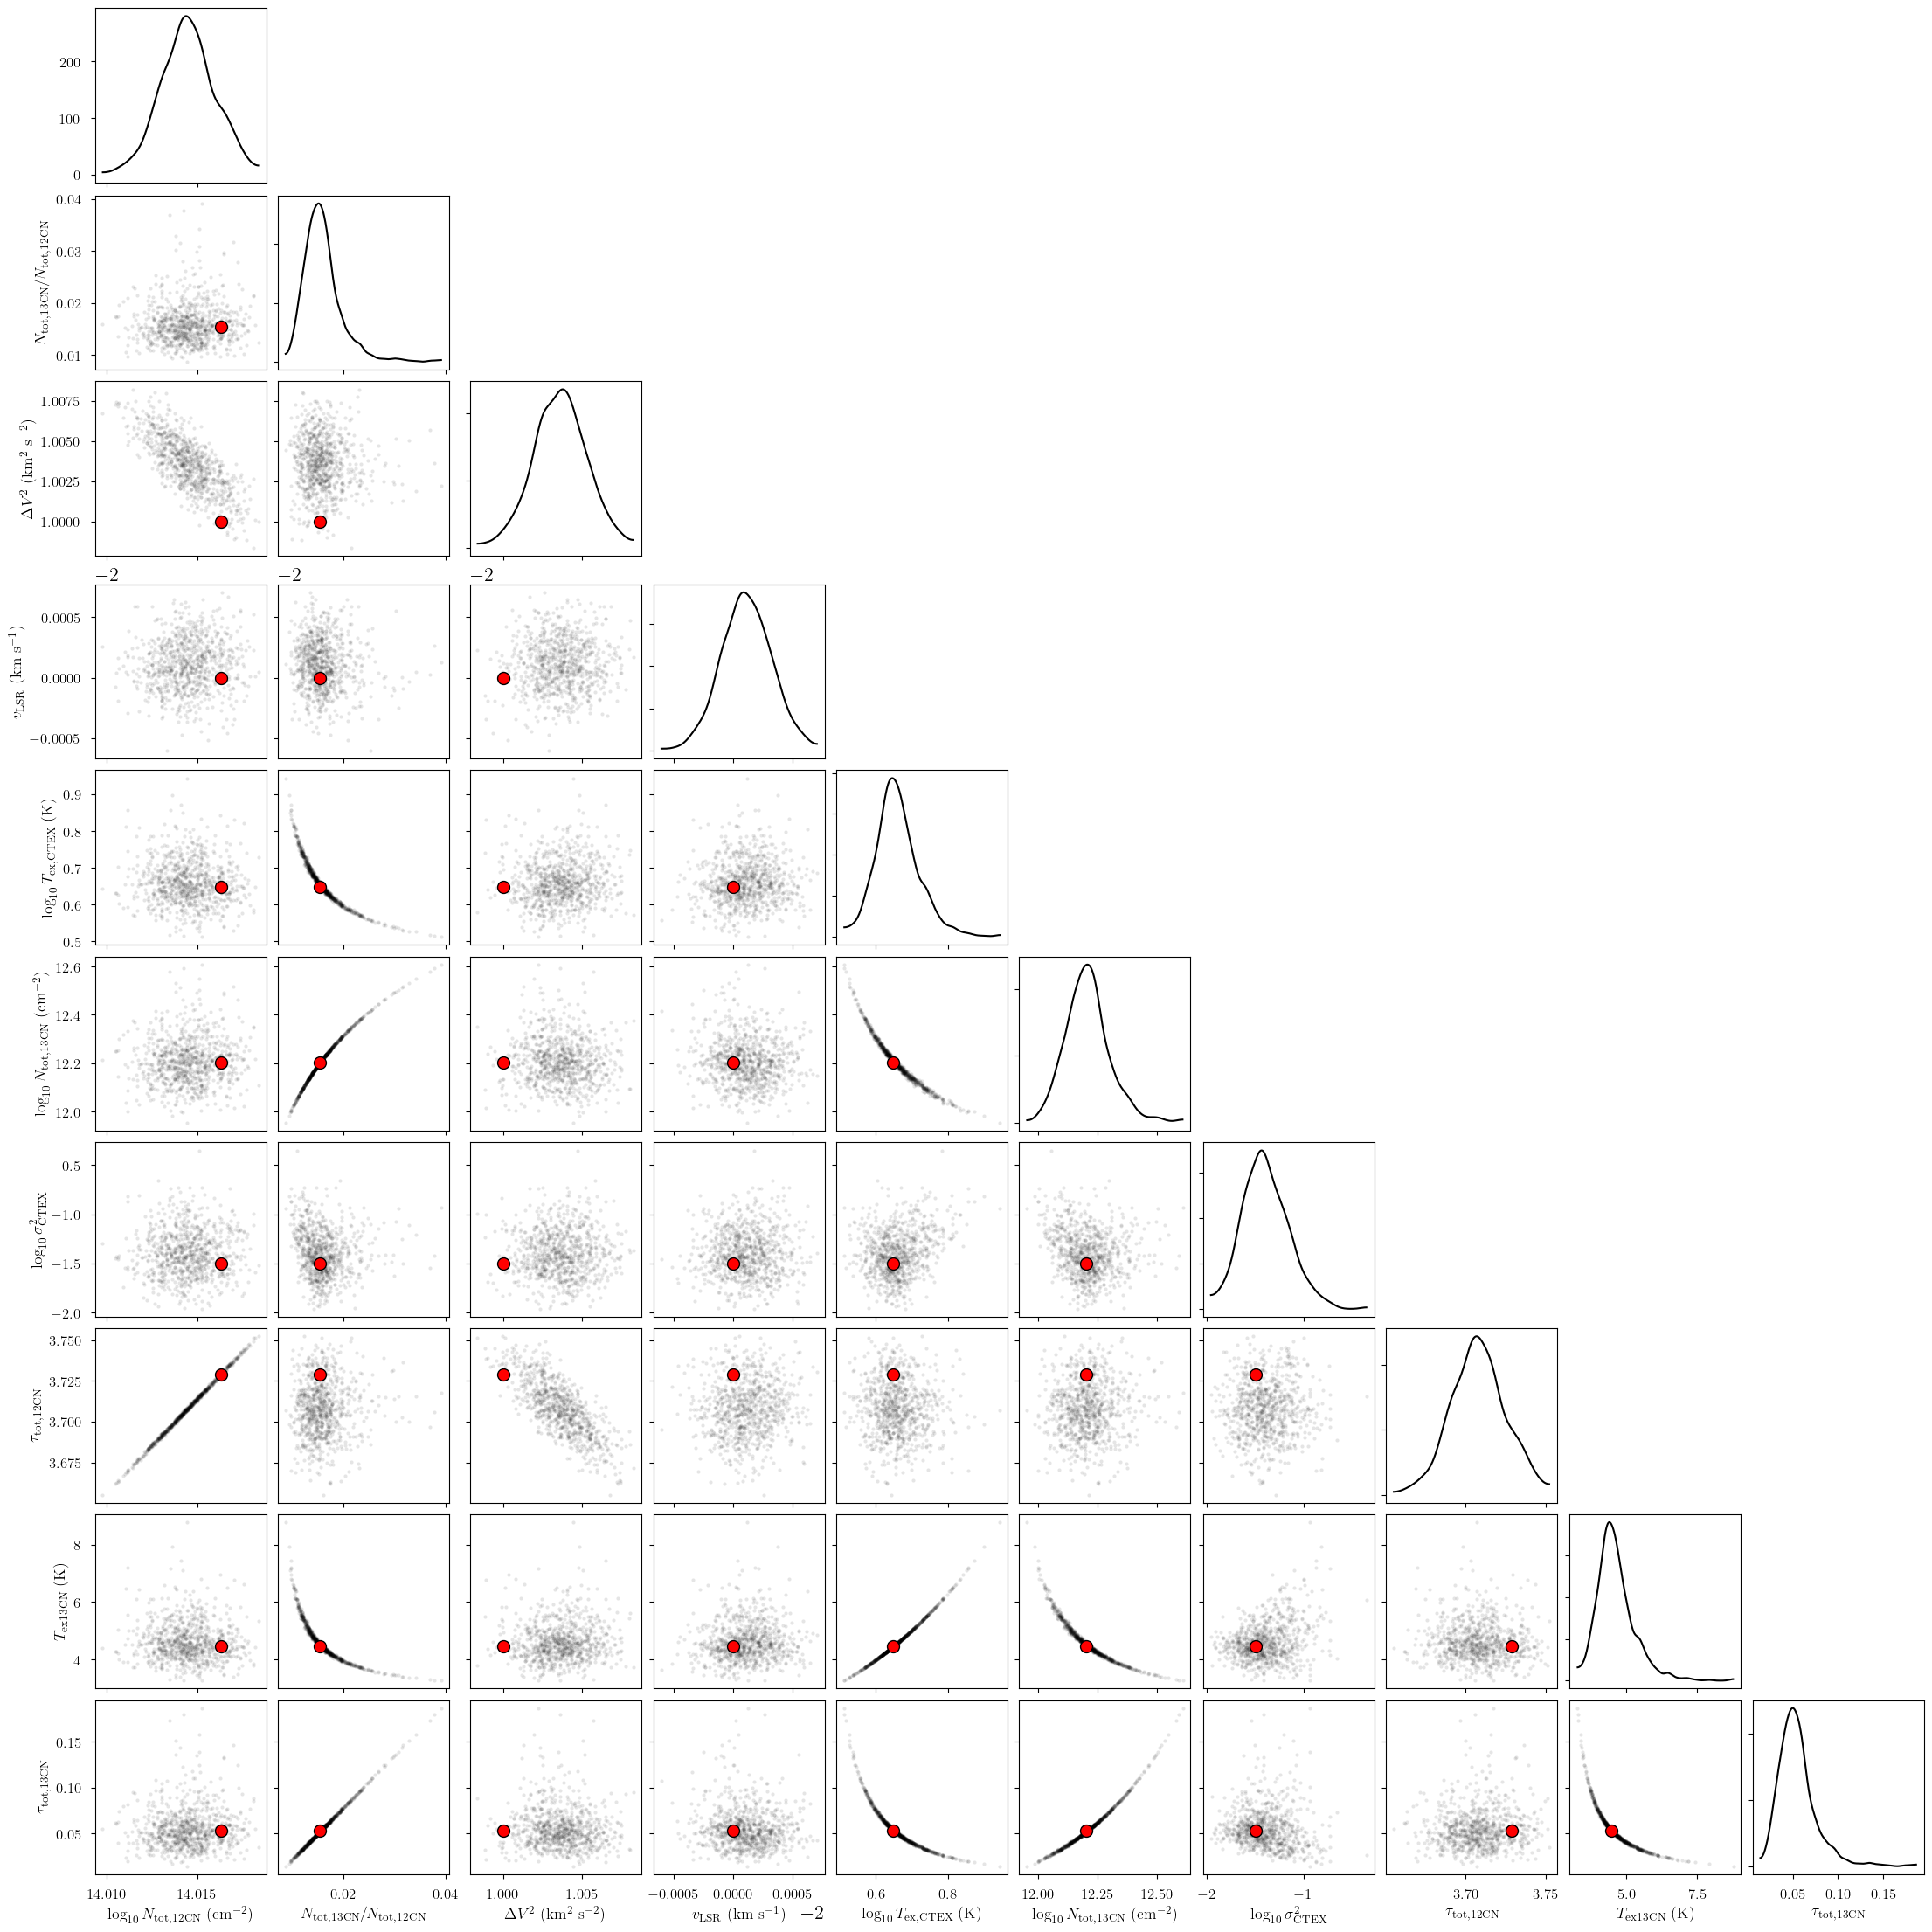

In [33]:
cloud = 0

# subset of sim_params
my_sim_params = {}
for var_name in var_names:
    my_sim_params[var_name] = sim_params[var_name][sim_cloud_map[cloud]]

_ = plot_pair(
    model.trace.solution_0.sel(cloud=cloud, draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="scatter", # plot type
    reference_values=my_sim_params, # truths
)

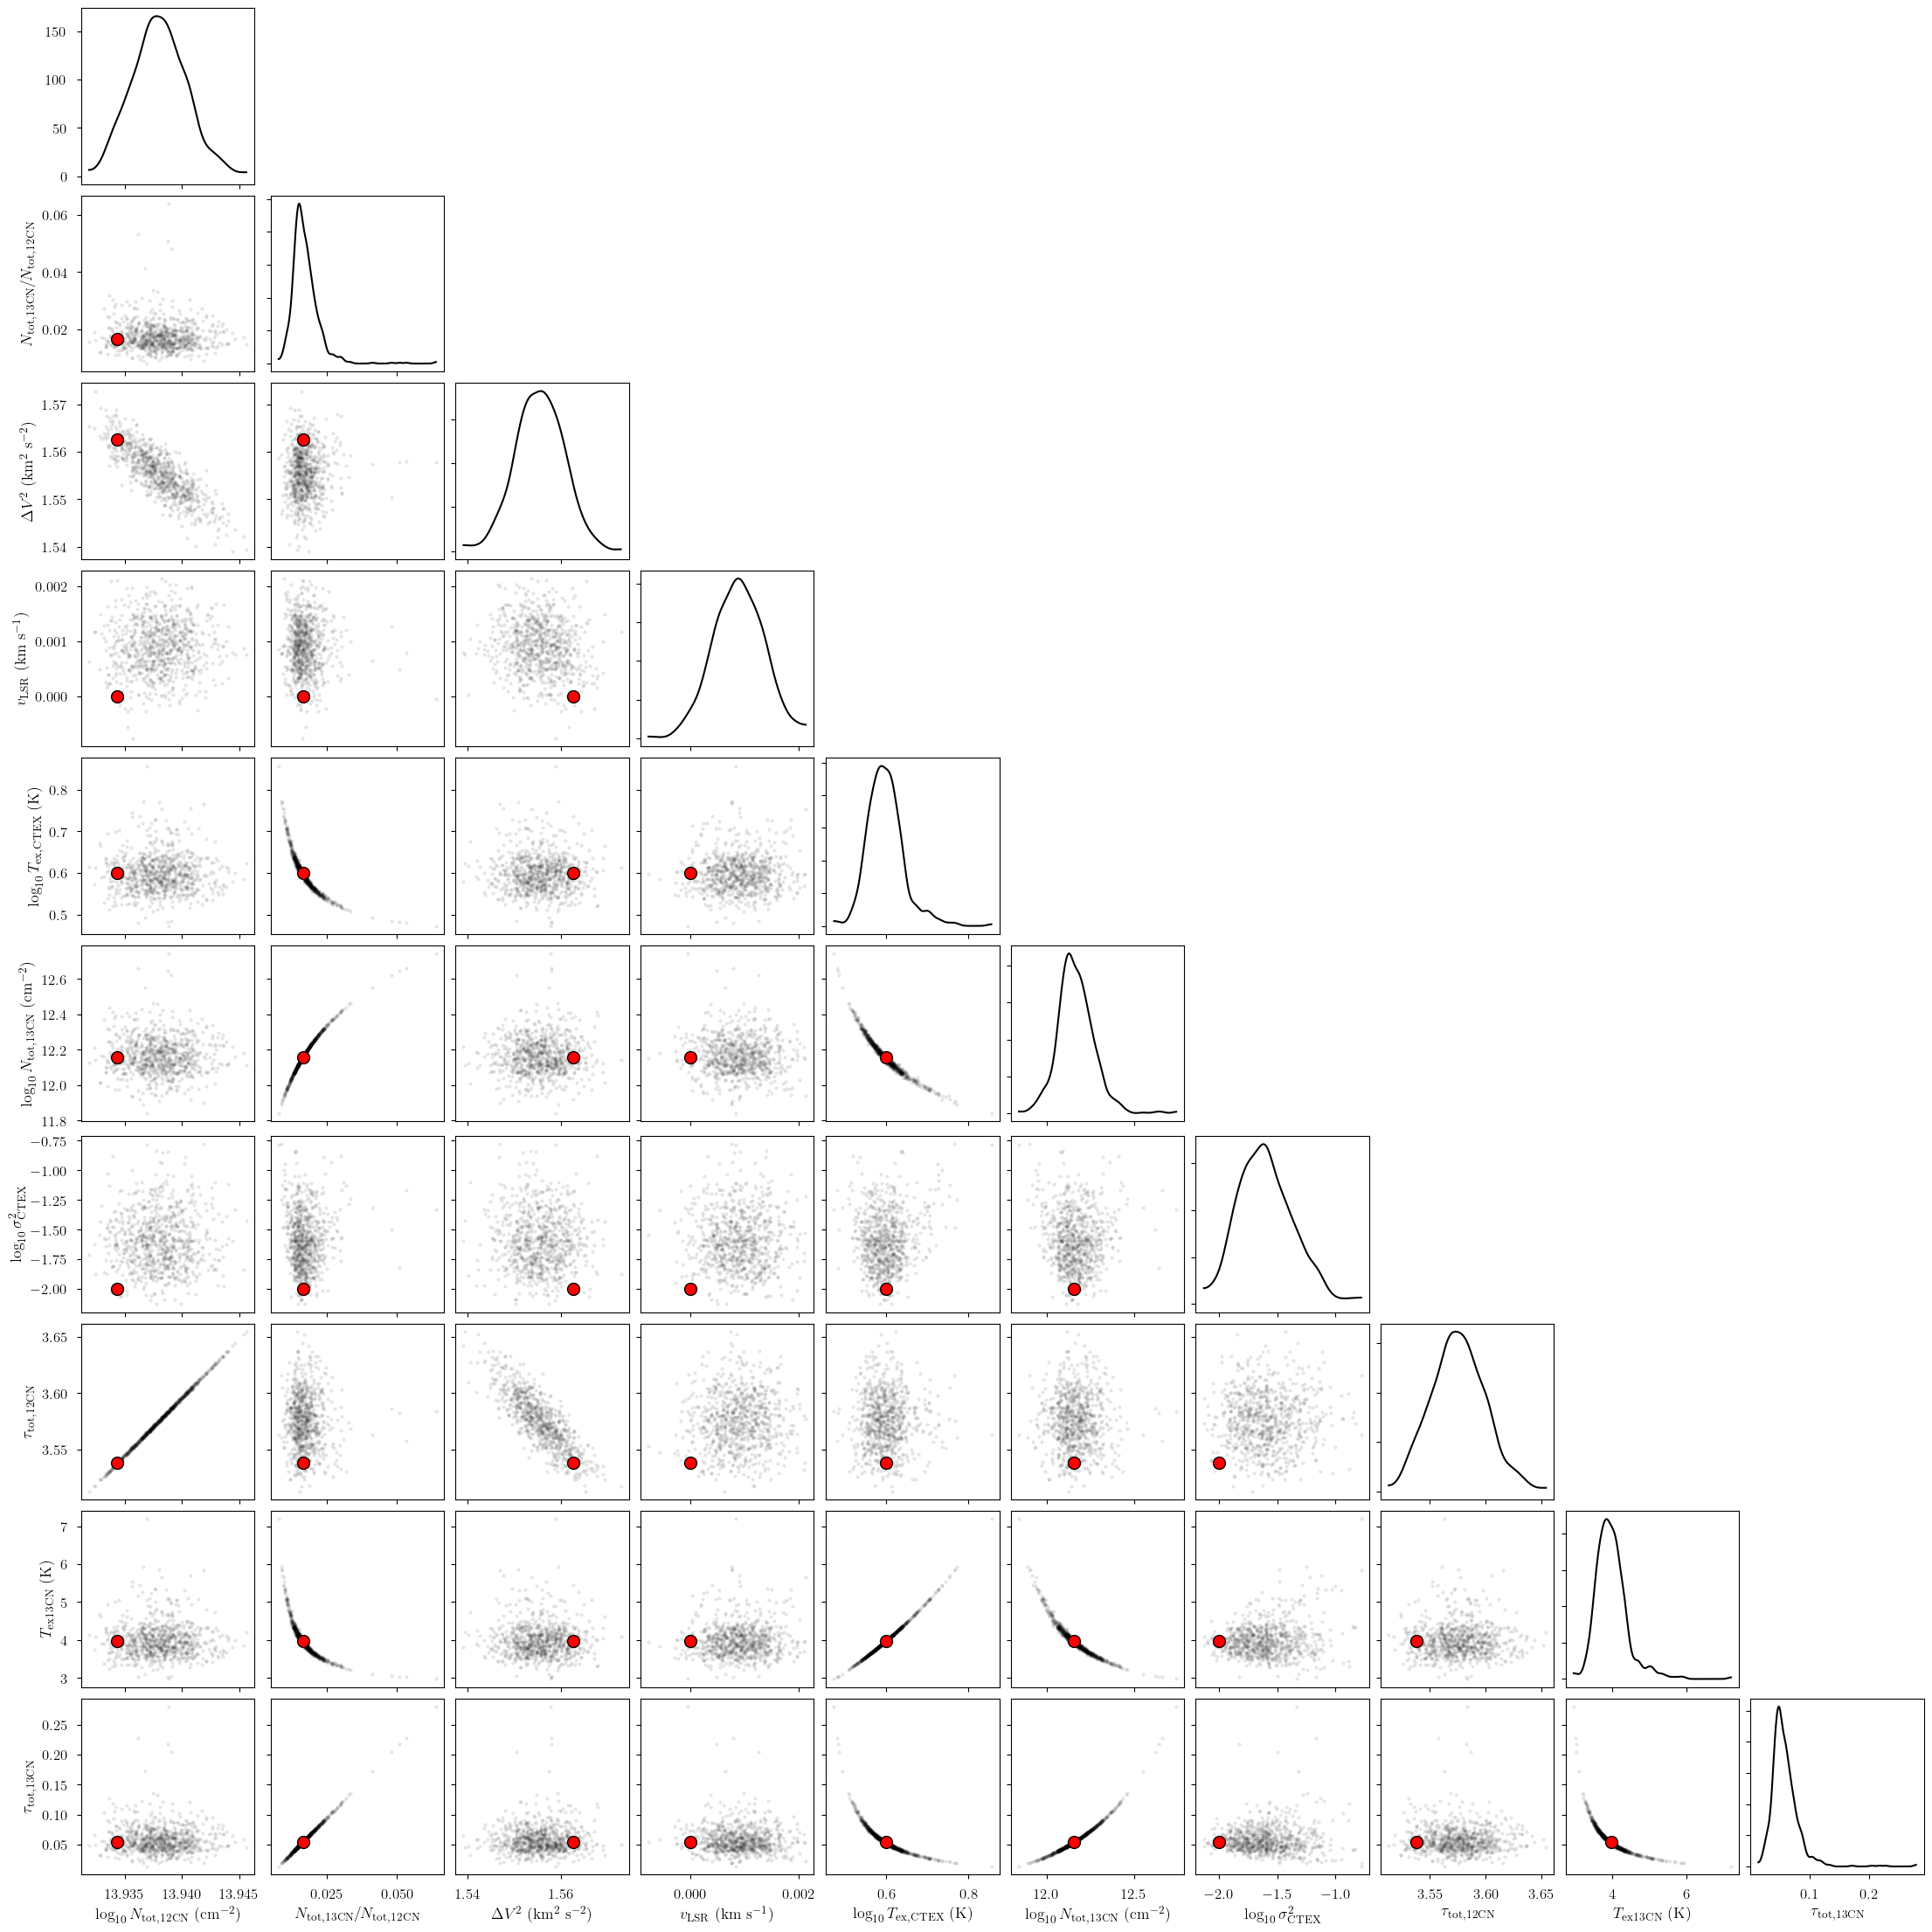

In [34]:
cloud = 1

# subset of sim_params
my_sim_params = {}
for var_name in var_names:
    my_sim_params[var_name] = sim_params[var_name][sim_cloud_map[cloud]]

_ = plot_pair(
    model.trace.solution_0.sel(cloud=cloud, draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="scatter", # plot type
    reference_values=my_sim_params, # truths
)

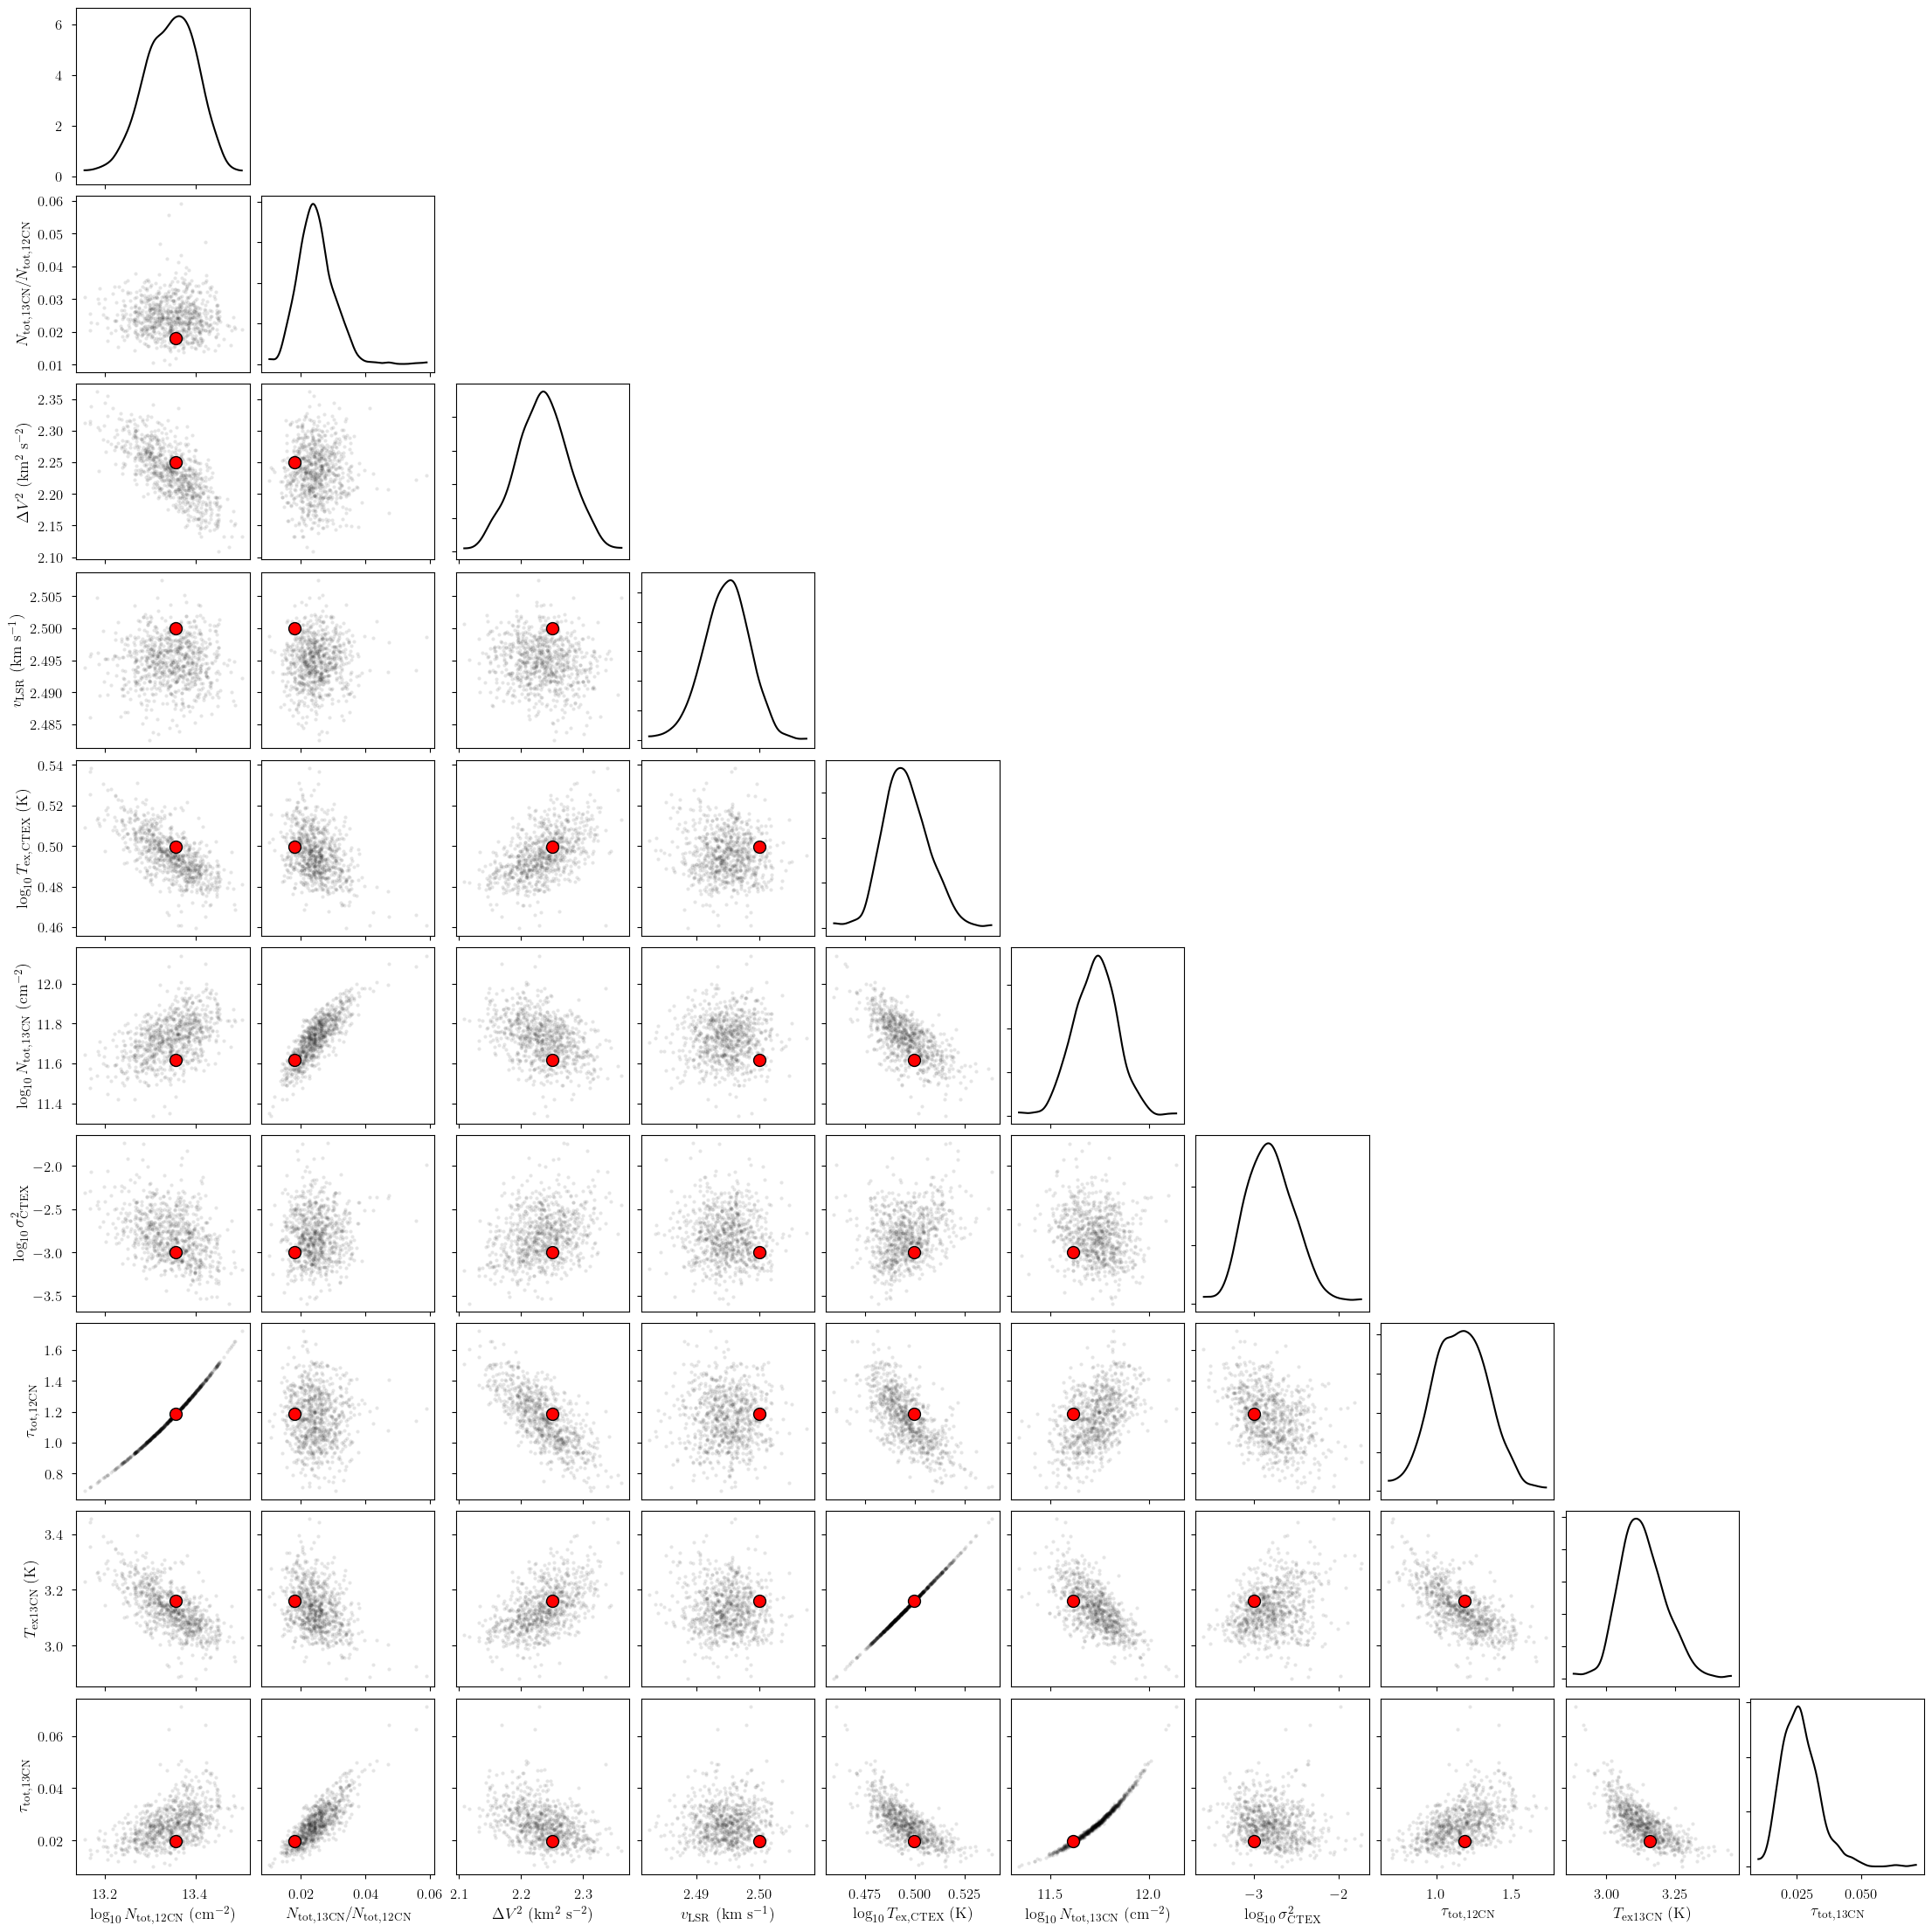

In [35]:
cloud = 2

# subset of sim_params
my_sim_params = {}
for var_name in var_names:
    my_sim_params[var_name] = sim_params[var_name][sim_cloud_map[cloud]]

_ = plot_pair(
    model.trace.solution_0.sel(cloud=cloud, draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="scatter", # plot type
    reference_values=my_sim_params, # truths
)

In [36]:
point_stats = az.summary(model.trace.solution_0, kind='stats')
print("BIC:", model.bic())
display(point_stats)

BIC: -12854.747641384365


mean     sd  hdi_3%  hdi_97%
baseline_12CN-1_norm[0]               0.023  0.049  -0.069    0.115
baseline_12CN-2_norm[0]              -0.050  0.064  -0.175    0.066
baseline_13CN-1_norm[0]               0.035  0.068  -0.093    0.164
baseline_13CN-2_norm[0]              -0.097  0.075  -0.233    0.051
log10_Ntot_12CN_norm[0]               1.029  0.003   1.023    1.034
log10_Ntot_12CN_norm[1]               0.876  0.005   0.867    0.885
log10_Ntot_12CN_norm[2]              -0.313  0.121  -0.551   -0.102
log10_Tex_CTEX_norm[0]               -0.355  0.244  -0.802    0.092
log10_Tex_CTEX_norm[1]               -0.605  0.174  -0.926   -0.273
log10_Tex_CTEX_norm[2]               -1.015  0.050  -1.103   -0.919
ratio_norm[0]                         0.160  0.037   0.097    0.224
ratio_norm[1]                         0.175  0.055   0.106    0.258
ratio_norm[2]                         0.248  0.057   0.147    0.350
fwhm2_norm[0]                         1.003  0.002   1.000    1.007
fwhm2_norm[1]                         1.556  0.005   1.546    1.565
fwhm2_norm[2]                         2.233  0.043   2.149    2.311
velocity_norm[0]                      0.167  0.000   0.167    0.167
velocity_norm[1]                      0.500  0.000   0.500    0.500
velocity_norm[2]                      0.916  0.001   0.915    0.917
log10_CTEX_variance_norm[0]           2.606  0.236   2.181    3.063
log10_CTEX_variance_norm[1]           2.410  0.236   1.999    2.866
log10_CTEX_variance_norm[2]           1.202  0.288   0.686    1.740
weights_12CN_norm[0, 0 0 1 1 -- --]   0.197  0.000   0.197    0.197
weights_12CN_norm[0, 0 0 1 2 -- --]   0.332  0.000   0.331    0.332
weights_12CN_norm[0, 1 0 1 1 -- --]   0.044  0.000   0.044    0.044
weights_12CN_norm[0, 1 0 1 2 -- --]   0.126  0.000   0.126    0.126
weights_12CN_norm[0, 1 0 2 1 -- --]   0.079  0.000   0.079    0.079
weights_12CN_norm[0, 1 0 2 2 -- --]   0.112  0.000   0.112    0.113
weights_12CN_norm[0, 1 0 2 3 -- --]   0.110  0.000   0.110    0.110
weights_12CN_norm[1, 0 0 1 1 -- --]   0.158  0.000   0.157    0.159
weights_12CN_norm[1, 0 0 1 2 -- --]   0.413  0.000   0.412    0.413
weights_12CN_norm[1, 1 0 1 1 -- --]   0.047  0.000   0.046    0.047
weights_12CN_norm[1, 1 0 1 2 -- --]   0.073  0.000   0.073    0.073
weights_12CN_norm[1, 1 0 2 1 -- --]   0.038  0.000   0.038    0.038
weights_12CN_norm[1, 1 0 2 2 -- --]   0.100  0.000   0.100    0.100
weights_12CN_norm[1, 1 0 2 3 -- --]   0.172  0.000   0.171    0.172
weights_12CN_norm[2, 0 0 1 1 -- --]   0.212  0.003   0.205    0.217
weights_12CN_norm[2, 0 0 1 2 -- --]   0.442  0.004   0.434    0.449
weights_12CN_norm[2, 1 0 1 1 -- --]   0.037  0.001   0.035    0.038
weights_12CN_norm[2, 1 0 1 2 -- --]   0.080  0.002   0.076    0.084
weights_12CN_norm[2, 1 0 2 1 -- --]   0.040  0.001   0.038    0.043
weights_12CN_norm[2, 1 0 2 2 -- --]   0.081  0.002   0.077    0.085
weights_12CN_norm[2, 1 0 2 3 -- --]   0.109  0.001   0.106    0.111
log10_Ntot_12CN[0]                   14.015  0.001  14.012   14.017
log10_Ntot_12CN[1]                   13.938  0.002  13.933   13.942
log10_Ntot_12CN[2]                   13.344  0.060  13.224   13.449
ratio[0]                              0.016  0.004   0.010    0.022
ratio[1]                              0.018  0.005   0.011    0.026
ratio[2]                              0.025  0.006   0.015    0.035
fwhm2[0]                              1.003  0.002   1.000    1.007
fwhm2[1]                              1.556  0.005   1.546    1.565
fwhm2[2]                              2.233  0.043   2.149    2.311
velocity[0]                          -2.000  0.000  -2.000   -2.000
velocity[1]                           0.001  0.000   0.000    0.002
velocity[2]                           2.495  0.004   2.488    2.502
log10_Tex_CTEX[0]                     0.661  0.061   0.549    0.773
log10_Tex_CTEX[1]                     0.599  0.044   0.518    0.682
log10_Tex_CTEX[2]                     0.496  0.013   0.474    0.520
log10_Ntot_13CN[0]         